# Project: Bike Rental in Washington DC
---
## Introduction and Goal: 
---
If you aspire to be green and avoid your city's traffic but most important of all your city has a public bicycle sharing system like the Velib in France, the Santander Cycles in London or the Capital Bikeshare in Washington D.C. then you as a responsible Earth-dweller may have been confronted to two problems: not finding a bike in your nearest bike station and not finding a bike-free dock at your destination's dock. To answer this issue, the bike's company needs to know the variability of the demand throughout time. 

This project analyzes the variance of the demand in rental bikes in function of the time, day in the year as well as the weather. 

## Questions for Exploration
---
1. What's the distribution of the demand for rental bikes throughout time? Is the demand higher in the weekdays than the weekends? In any normal day, is there a pattern of the usage over the course of time? 

2. Is there a difference in usage between a casual and a registered user? (Are they statistically different?)

3. How influential is the weather with both users? Will a nice day be more enticing to use the bike over a rainy day? Does the wind or temperature discourage people to take the bike? 

4. Can the temperature felt be characterized by a combination of windspeed, humidity and official temperature? 

5. Can we predict the count of bikers given the time, day and weather? 

In [130]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime as dt

import scipy.stats as stats
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3
import missingno as msn
import itertools

# system packages 
import os, sys
import warnings
warnings.filterwarnings('ignore')

# File with functions from prior notebook(s)
from myfunk import *

pd.set_option('precision', 2)

# Update matplotlib defaults to something nicer 
plt_update = {'font.size':16,
              'xtick.labelsize':14,
              'ytick.labelsize':14,
              'figure.figsize':[10.0,5.0],
              'axes.labelsize':20,
              'axes.titlesize':20,
              'lines.linewidth':3}
sns.set(style="darkgrid", color_codes=True)
plt.rcParams.update(plt_update)

## Acquire the data
---
The dataset is taken from Kaggle's Bike Sharing Dataset, containing data of rental bikes from Capital Bikeshare for the period between 2011 and 2012. This data is segmented by: 
- The number of bikes in use. 
- The user type: Registered and Casual (independent events)
- Date (segmented in year, month and day) and time represented by the hour of use. 
- Whether the day is a holiday or not, a working day or a weekend. 


Moreover the weather information from freemeteo.com is merged with the dataframe adding 4 columns: 
- A brief categorical description of the sky (clear, scattered clouds, light rain, heavy snow or rain)
- Temperature in celsius normalized by a factor of 41, 
- Feeling temperature in Celsius normalized by a factor of 50, 
- Normalized Humidity by a factor of 100 and 
- Normalized Windspeed by a factor of 67

In [3]:
raw_data = '../data/raw/hour.csv'
data = pd.read_csv(raw_data, index_col=0, parse_dates=True)
data.head(1)

dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
instant                                                                   
1        2011-01-01       1   0     1   0        0        6           0   

         weathersit  temp  atemp   hum  windspeed  casual  registered  cnt  
instant                                                                     
1                 1  0.24   0.29  0.81        0.0       3          13   16

## Exploring and Cleaning data
---
We will be performing the following operation on our data to refine it

Remove e.g. remove any redundant data from the data frame
> Instant, weekday, season? etc...

Parse e.g. convert strings to timestamps and extract date & time components to columns
> Datetime to datetime

Set the adequate data types
> Int for date data

>Float for weather data

Missing e.g. handle missing or incomplete data
>Some records from early hours such as 3am, 5am, etc., are missing so the dataset will be resampled with daily periods. 

Quality e.g. Outliers
> Play results with and without the outliers

Calculate e.g. percentages, proportion ***Normalize cnt***
> Normalize the number of bikes per day 

Summary e.g. show summary stats like mean

In [4]:
# Reset index
data.reset_index(inplace=True)
data.drop('instant', axis=1, inplace=True)

In [5]:
# Rename columns to meaningful words

data.rename(columns={
                        'dteday':'date',
                        'weekday':'dow',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

# Parse Date: convert strings to timestamps and extract date & time components to columns

# function to convert `Date` to datetime Timestamp objects
f_date = lambda x: dt.strptime(x, '%Y-%m-%d')
data.loc[:, 'date'] = data.loc[:, 'date'].apply(f_date)
# Get the year
data['year'] = pd.Series(data.date).apply(lambda x: x.year)

___

In [6]:
data.loc[28:30]

date  season  year  month  hour  holiday  dow  workingday  \
28 2011-01-02       1  2011      1     4        0    0           0   
29 2011-01-02       1  2011      1     6        0    0           0   
30 2011-01-02       1  2011      1     7        0    0           0   

    weather_condition  temp  atemp  humidity  windspeed  casual  registered  \
28                  2  0.46   0.45      0.94       0.19       2           1   
29                  3  0.42   0.42      0.77       0.30       0           2   
30                  2  0.40   0.41      0.76       0.19       0           1   

    cnt  
28    3  
29    2  
30    1

In [7]:
# Missing Data
d = data.loc[(data.year==2011)&(data.month==1),['date','hour','cnt']] #data.loc[:,['date','hour','cnt']]
d.set_index(['date','hour'], inplace=True)
d.sort_index(inplace=True)
m = d.unstack().T
#msn.matrix(m.T, figsize=(25,7))

In [8]:
print(m.isnull().sum().sum()/(m.shape[0]*m.shape[1])*100,'% of the values are missing')

7.52688172043 % of the values are missing


There are some missing values, ideally a filling function could consider the hour of missing values as well as the trend of the non missing values throughout the remaining hours of the day. So an interpolation from the previous hour and the next seems appropriate. 

In [9]:
d_ints = fill_missin(data.loc[:,['date','season','year','month','hour','holiday','dow','workingday','weather_condition','casual','registered','cnt']], 1)
d_floats = fill_missin(data.loc[:,['date','hour','temp','atemp','humidity','windspeed']],0)
d_floats.drop(['date','hour'], axis=1, inplace=True)
# Merge 
data = pd.merge(d_ints, d_floats, right_index=True, left_index=True)
data.loc[28:30]

date  hour  season  year  month  holiday  dow  workingday  \
28 2011-01-02     4       1  2011      1        0    0           0   
29 2011-01-02     5       1  2011      1        0    0           0   
30 2011-01-02     6       1  2011      1        0    0           0   

    weather_condition  casual  registered  cnt  temp  atemp  humidity  \
28                  2       2           1    3  0.46   0.45      0.94   
29                  2       1           1    2  0.44   0.44      0.85   
30                  3       0           2    2  0.42   0.42      0.77   

    windspeed  
28       0.19  
29       0.25  
30       0.30

---

#### Normalization
The demand distributions are right skewed with several outliers. To correct this, these values will be normalized in function of the total demand per day. 

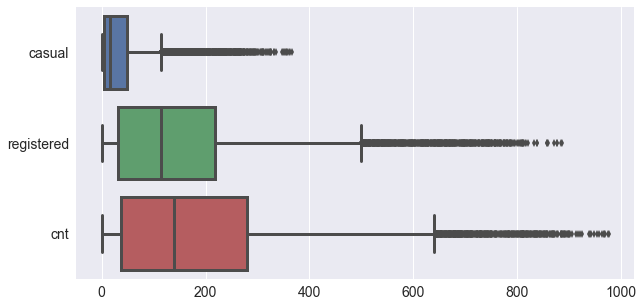

In [10]:
sns.boxplot(data=data.loc[:,['casual','registered','cnt']], orient="h")
plt.show()

In [11]:
# Normalize the user types counts: 
data = normalize_data(data.loc[:,['date','hour','cnt']], data)
data = normalize_data(data.loc[:,['date','hour','casual']], data)
data = normalize_data(data.loc[:,['date','hour','registered']], data)

In [12]:
# Drop uneccessary columns ?
data.head(1)

date  hour  season  year  month  holiday  dow  workingday  \
1 2011-01-01     1       1  2011      1        0    6           0   

   weather_condition  casual  registered  cnt  temp  atemp  humidity  \
1                  1       8          32   40  0.22   0.27       0.8   

   windspeed  nCnt  nCasual  nRegistered  
1        0.0  0.02     0.02         0.05

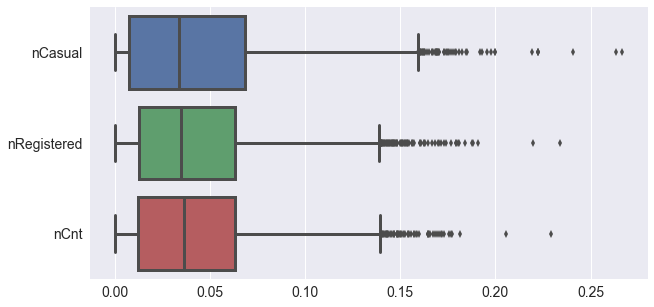

In [13]:
sns.boxplot(data=data.loc[:,['nCasual','nRegistered','nCnt']], orient="h")
plt.show()

Above we are watching at box plot (distribution) of the daily demand per hour. Outliers here represent some hours where the demand got high with respect to the other hours in that day where the demand so low it could be considered as negligeable. 

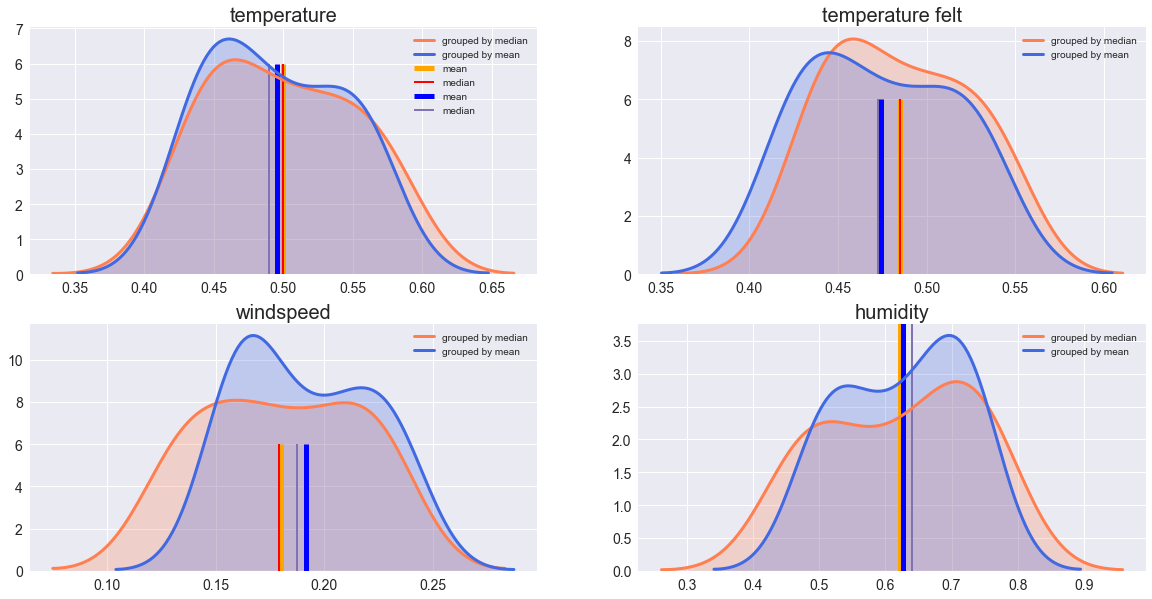

In [14]:
gather_weather_data_per_hour(data)

The figure above shows some distributions grouped by day in function of their mean and their median. The weather factors that are **grouped by median** are now more resistant to outliers, moreover they  have lower values of skewness and kurtosis. Thus the sampling method will use the median. 

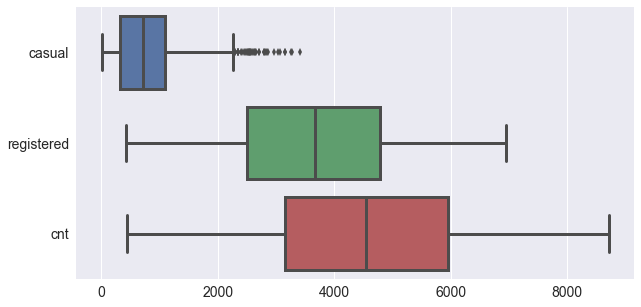

In [15]:
# Day Sampling
#taking the median from the weather factors and the sum of the number of bikes rented throughout the day. 
dayta_time = data.loc[:,['date','season','year','month','holiday','dow','workingday','weather_condition']].set_index('date').resample('D').median().astype('int')
dayta_weather = data.loc[:,['date','temp','atemp','windspeed', 'humidity']].set_index('date').resample('D').median()
dayta_demand = data.loc[:,['date','casual','registered','cnt']].set_index('date').resample('D').sum()
sns.boxplot(data=dayta_demand, orient="h")
plt.show()

The day sampling behaves more normally than the hourly sampling. Without outliers on the total and registered count, these two distributions seem pretty normal. 

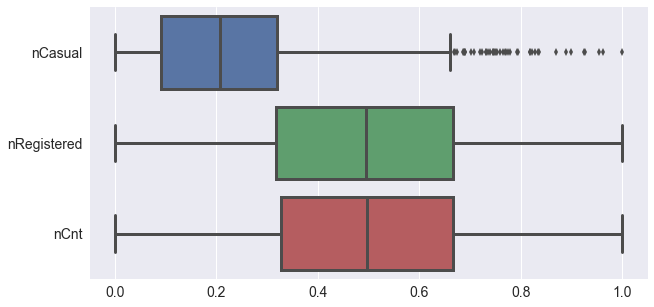

In [16]:
# Normalize demand in function of the day where the demand was the highest and the day where the demand was the lowest. 
dayta_demand['nCasual'] = dayta_demand.casual.apply(lambda x:(x-min(dayta_demand.casual))/(max(dayta_demand.casual)-min(dayta_demand.casual)))
dayta_demand['nRegistered'] = dayta_demand.registered.apply(lambda x:(x-min(dayta_demand.registered))/(max(dayta_demand.registered)-min(dayta_demand.registered)))
dayta_demand['nCnt'] = dayta_demand.cnt.apply(lambda x:(x-min(dayta_demand.cnt))/(max(dayta_demand.cnt)-min(dayta_demand.cnt)))

sns.boxplot(data=dayta_demand.loc[:,['nCasual','nRegistered','nCnt']], orient="h")
plt.show()

In [17]:
# Merge 
dayta = pd.merge(dayta_time, dayta_weather, right_index=True, left_index=True)
dayta = pd.merge(dayta, dayta_demand, right_index=True, left_index=True)
dayta.head(2)

season  year  month  holiday  dow  workingday  weather_condition  \
date                                                                           
2011-01-01       1  2011      1        0    6           0                  2   
2011-01-02       1  2011      1        0    0           0                  2   

            temp  atemp  windspeed  humidity  casual  registered  cnt  \
date                                                                    
2011-01-01  0.40   0.41       0.25      0.80     328         641  969   
2011-01-02  0.36   0.35       0.24      0.73     132         671  803   

            nCasual  nRegistered  nCnt  
date                                    
2011-01-01     0.09         0.03  0.06  
2011-01-02     0.04         0.04  0.04

In [18]:
# Week sampling
week_time = data.loc[:,['date','season','year']].set_index('date').resample('W').median().astype('int')
week_weather = data.loc[:,['date','weather_condition','temp','atemp','windspeed', 'humidity']].set_index('date').resample('W').median()
week_demand = data.loc[:,['date','casual','registered','cnt']].set_index('date').resample('W').sum()
week_demand.head()


casual  registered   cnt
date                                
2011-01-02     460        1312  1772
2011-01-09     668        8747  9415
2011-01-16     674        8369  9043
2011-01-23     611        8190  8904
2011-01-30     683        7396  8187

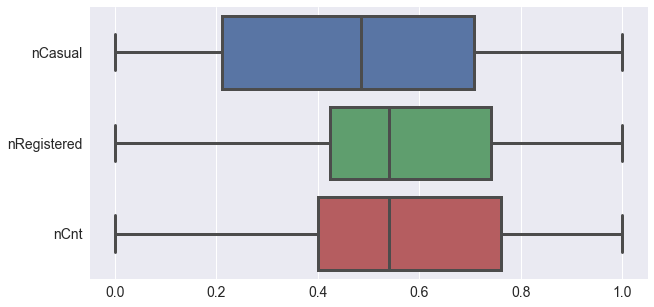

In [19]:
week_demand['nCasual'] = week_demand.casual.apply(lambda x:(x-min(week_demand.casual))/(max(week_demand.casual)-min(week_demand.casual)))
week_demand['nRegistered'] = week_demand.registered.apply(lambda x:(x-min(week_demand.registered))/(max(week_demand.registered)-min(week_demand.registered)))
week_demand['nCnt'] = week_demand.cnt.apply(lambda x:(x-min(week_demand.cnt))/(max(week_demand.cnt)-min(week_demand.cnt)))

sns.boxplot(data=week_demand.loc[:,['nCasual','nRegistered','nCnt']], orient="h")
plt.show()

In [20]:
# Merge
# Merge 
week_data = pd.merge(week_time, week_weather, right_index=True, left_index=True)
week_data = pd.merge(week_data, week_demand, right_index=True, left_index=True)
week_data.head(2)

season  year  weather_condition  temp  atemp  windspeed  humidity  \
date                                                                            
2011-01-02       1  2011                2.0  0.36   0.35       0.25      0.77   
2011-01-09       1  2011                1.0  0.20   0.20       0.19      0.47   

            casual  registered   cnt   nCasual  nRegistered  nCnt  
date                                                               
2011-01-02     460        1312  1772  1.80e-03         0.00  0.00  
2011-01-09     668        8747  9415  1.96e-02         0.17  0.14

### Save data
___

In [21]:
data.to_csv('../data/processed/data.csv')
dayta.to_csv('../data/processed/dayta.csv')
week_data.to_csv('../data/processed/week_data.csv')
save_tables('../data/interim/database.sqlite', data, dayta, week_data)

Tables Saved to ../data/interim/database.sqlite


# Questions
---

### Load Data

In [22]:
int_data = '../data/processed/data.csv'
data = pd.read_csv(int_data, index_col=0, parse_dates=['date'])
int_data = '../data/processed/dayta.csv'
dayta = pd.read_csv(int_data, index_col=0, parse_dates=['date'])
int_data = '../data/processed/week_data.csv'
week_data = pd.read_csv(int_data, index_col=0, parse_dates=['date'])

## What's the distribution of the demand for rental bikes throughout the day?
The purpose of this analysis is to see how the demand of the service fluctuates throughout the week and thus develop a model for the supply chain to keep the demand satisfied. I will consider the demand between these two groups as not dependent since a weekday-user can and cannot be a weekend user and viceversa.
Below are the results of a 2 sample t-test (unpaired) with equal variance since we want to compare data between these two measurements. 

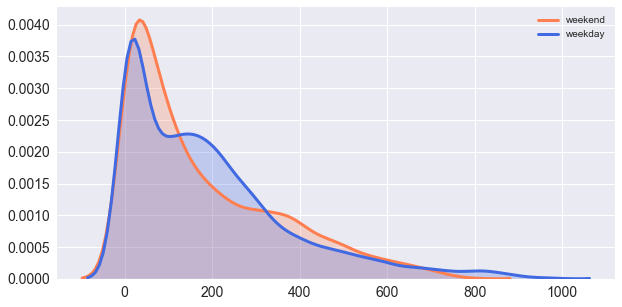

T-test 1: Ttest_indResult(statistic=-3.8760221348343125, pvalue=0.00010656536749463026)


In [23]:
# PROOF: There is a difference between the demand on the weekends or holidays, and the weekdays
weekend = data.loc[(data.workingday==0)|(data.holiday==1)]
weekday = data.loc[(data.workingday==1)&(data.holiday==0)]
fig1 = plt.figure()
p1=sns.kdeplot(weekend.cnt, shade=True, color="coral", label='weekend')
p2=sns.kdeplot(weekday.cnt, shade=True, color="royalblue", label='weekday')
plt.legend()
plt.show()
print('T-test 1:',stats.ttest_ind(a = weekend.cnt, b = weekday.cnt))
fig1.savefig('../reports/img/Q1WeekendVsWeekday.png', bbox_inches='tight')

The p-value is lower than our significance level (0.05) so we should **reject the null hypothesis.** If we were to construct a 95% confidence interval for the sample it would not capture the weekdays mean. ***Therefore the demand in the weekends is different (statistically significant) than in the weekdays.***

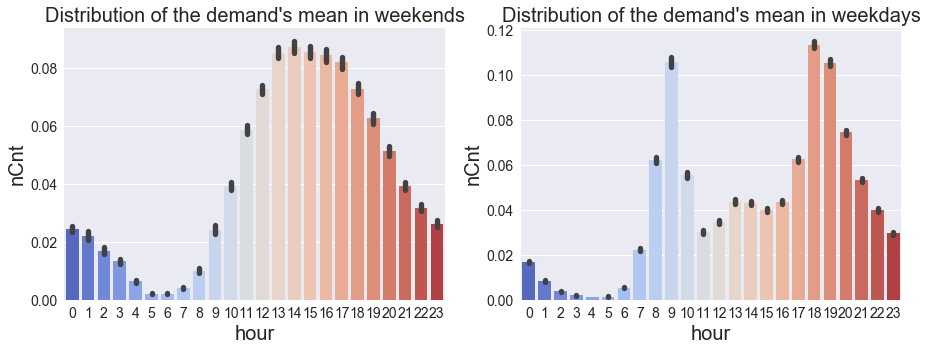

In [24]:
we_per_hr = weekend.loc[:,['hour','nCnt']] 
wd_per_hr = weekday.loc[:,['hour','nCnt']]

fig = plt.figure(figsize=(15,5))
axes1 = fig.add_subplot(1,2,1)
sns.barplot(x="hour", y="nCnt", data=we_per_hr, palette='coolwarm').set_title("Distribution of the demand's mean in weekends")

axes2 = fig.add_subplot(1,2,2)
sns.barplot(x="hour", y="nCnt", data=wd_per_hr, palette='coolwarm').set_title("Distribution of the demand's mean in weekdays")

plt.show()
fig.savefig('../reports/img/Q1WeekendVsWeekdayTS.png', bbox_inches='tight')

In the weekends bikers start their day around 9am and then it goes incrementally til 1pm to then begin a smooth decline in the late night hours and reach an inactivity state around 5am-6am. 
Activity on the weekdays appears to have 2 peaks, one at 9am and the other one at 6pm. The comparison made by the t-test is now visually noticeable so we can appreciate how the demand is different between these 2 groups of the week. 

## Is there a difference in usage between a casual and a registered user?
The figure below shows a comparisson of the distributions of the number of bikes in use by registered vs casual users in function the time of day and whether it's a holiday/weekend or just a normal weekday. 

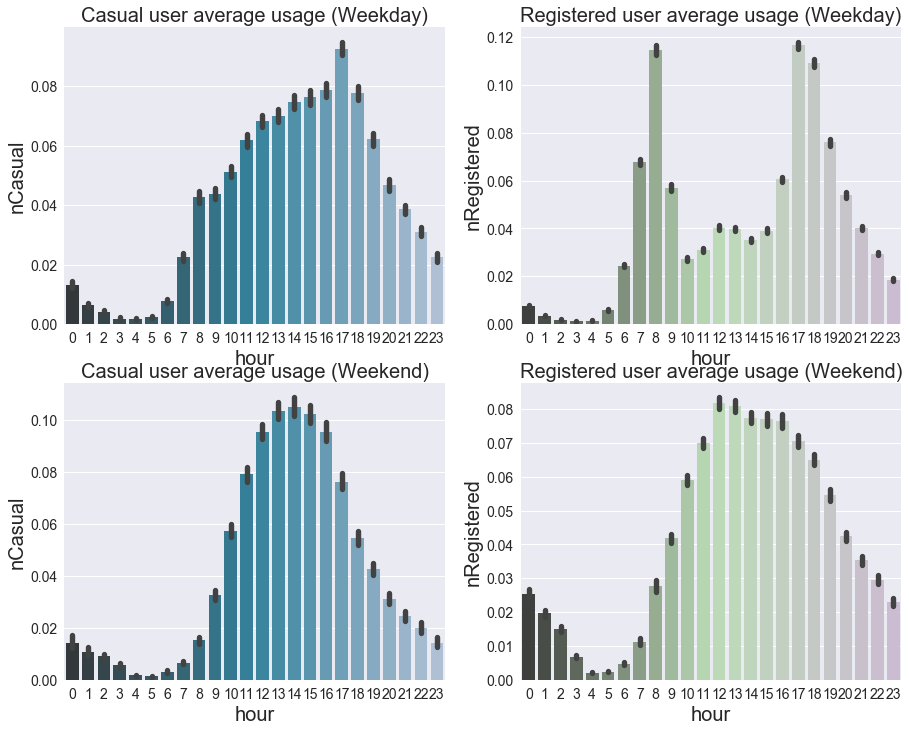

In [25]:
count_per_hr = weekday.loc[:,['hour','nCasual','nRegistered']]

fig = plt.figure(figsize=(15,12))
axes1 = fig.add_subplot(2,2,1)
sns.barplot(x="hour", y="nCasual", data=count_per_hr, palette="PuBuGn_d").set_title('Casual user average usage (Weekday)')

axes2 = fig.add_subplot(2,2,2)
sns.barplot(x="hour", y="nRegistered", data=count_per_hr, palette="PRGn_d").set_title('Registered user average usage (Weekday)')

count_per_hr = weekend.loc[:,['hour','nCasual','nRegistered']]

axes3 = fig.add_subplot(2,2,3)
sns.barplot(x="hour", y="nCasual", data=count_per_hr, palette="PuBuGn_d").set_title('Casual user average usage (Weekend)')

axes4 = fig.add_subplot(2,2,4)
sns.barplot(x="hour", y="nRegistered", data=count_per_hr, palette="PRGn_d").set_title('Registered user average usage (Weekend)')

plt.show()
fig.savefig('../reports/img/Q2CasualVsRegisteredTS.png', bbox_inches='tight')

Figures 1, 3 and 4 are show a similar usage. Figure 1 shows the average usage for the casual user on a weekday peaking at 5pm, where figure 3 shows the casual user on a weekend having a high demand in the afternoon and figure 4 are the registered users on a weekend also demanding high volumes of bikes starting at noon and carrying on in throughout the rest of the evening. 

It's important to consider that in the distribution of the demand's mean in weekdays graph, the influence of the casual users was not big enough to modify the shape of the distribution because the user type ratio is slightly higher than 6:1. 

We can notice that registered users are more intense over the weekends starting to bike earlier than their fellow casual users. So it is interesting to see if these 2 proportions are different from one each other in terms of bike usage. For that another 2 sample t-test will answer our question.  

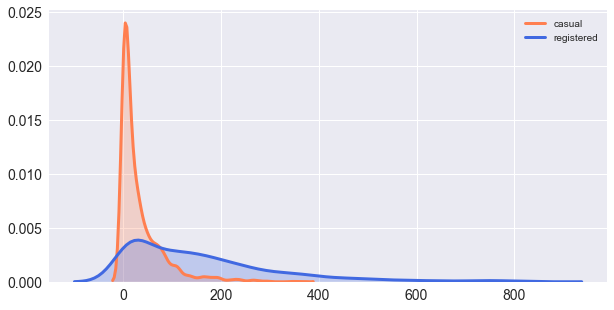

In [26]:
# Generate samples of 10% of the dataset's size of casual users and registered ones. 
sample_size = int(len(data)*0.1) # 10% of population count
random_index = random.sample(range(len(data)), sample_size)
sample_casual = data.loc[random_index,'casual']
random_index = random.sample(range(len(data)), sample_size)
sample_registered = data.loc[random_index,'registered']

# 2 sample t-test
fig = plt.figure()
p1=sns.kdeplot(sample_casual, shade=True, color="coral")
p2=sns.kdeplot(sample_registered, shade=True, color="royalblue")
plt.show()
stats.ttest_ind(a= sample_casual,
                b= sample_registered,
                equal_var=False) 
fig.savefig('../reports/img/Q2CasualVsRegisteredTTest.png', bbox_inches='tight')

The p-value is so small that the null hypothesis can be rejected and thus both groups are not identical but statistically different. 

## Can the *temperature felt* be characterized by a combination of windspeed, humidity and official temperature? 

A few weather forecasting websites claim that the feels-like-temperature is calculated in function of temperature, humidity and windspeed. I will attempt to find the specific coefficients of the weather predictors to determine it's relationship with the temperature felt. Below the pairplot will show evidence of a (linear or not) relationship

#### Sample per hour 

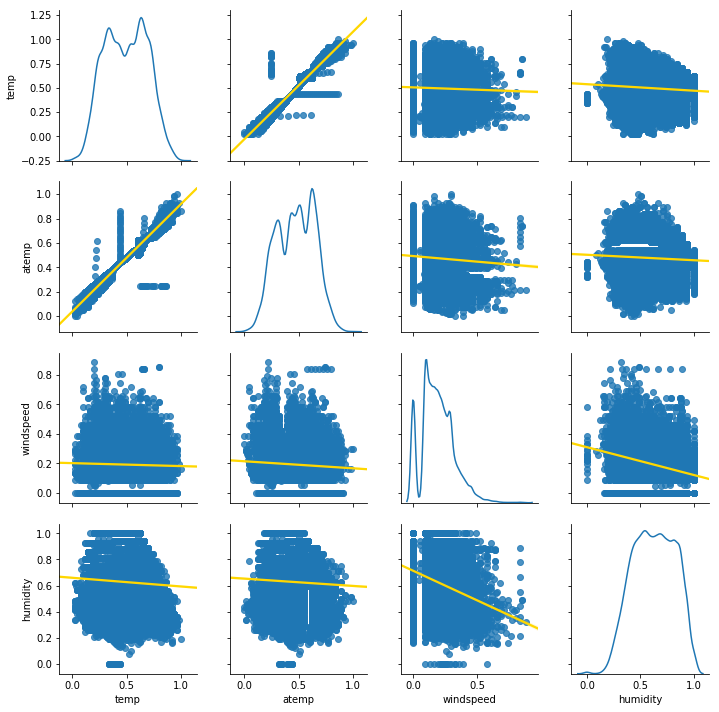

In [3]:
fig = plt.figure()
sns.pairplot(data.loc[:,['temp','atemp','windspeed', 'humidity']], kind="reg", plot_kws={'line_kws':{'color':'gold'}}, diag_kind="kde")
#fig.savefig('../reports/img/Q3WeatherPairPlot.png', bbox_inches='tight')

The scatter plot looks a bit noisy and with some outliers around the "feels like" temperature of 0.25. A re-sampling should improve the visibility of the possible relationship. 
#### Sampling per day
Which central metric can be used to represent the variables throughout the day. 

The figure below shows the distribution of each weather factor including every hour. It seems to be pretty much a normalized distribution. 

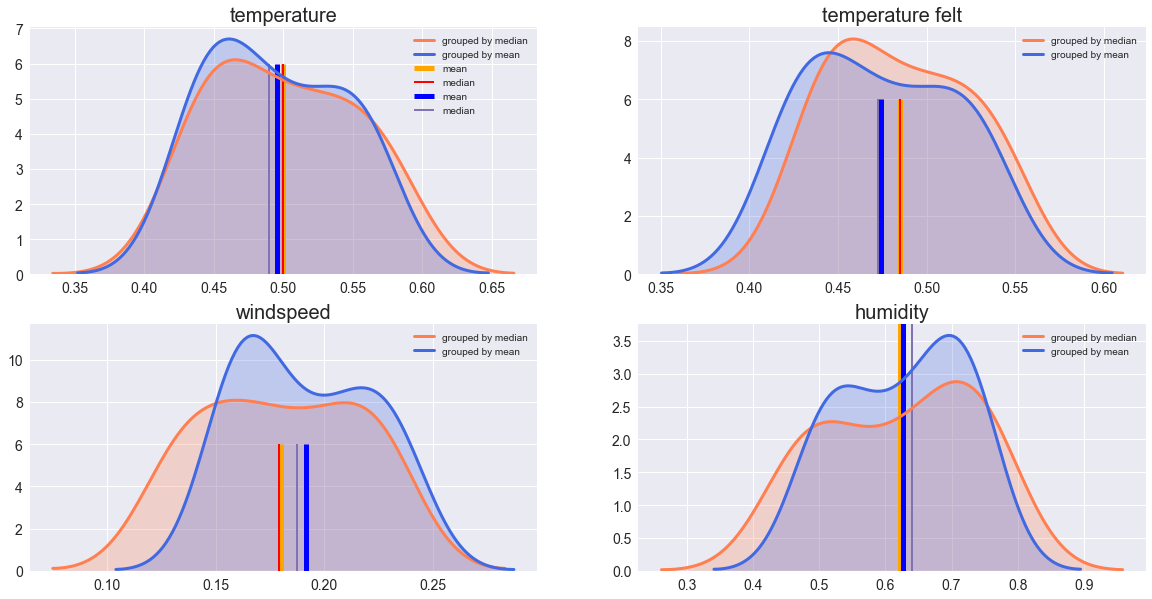

In [27]:
gather_weather_data_per_hour(data)

The weather factors **grouped by median** have lower values of skewness and kurtosis. 

Unfortunately the windspeed and the humidity show no relationship with other factors that can be deduced at the simple eye.

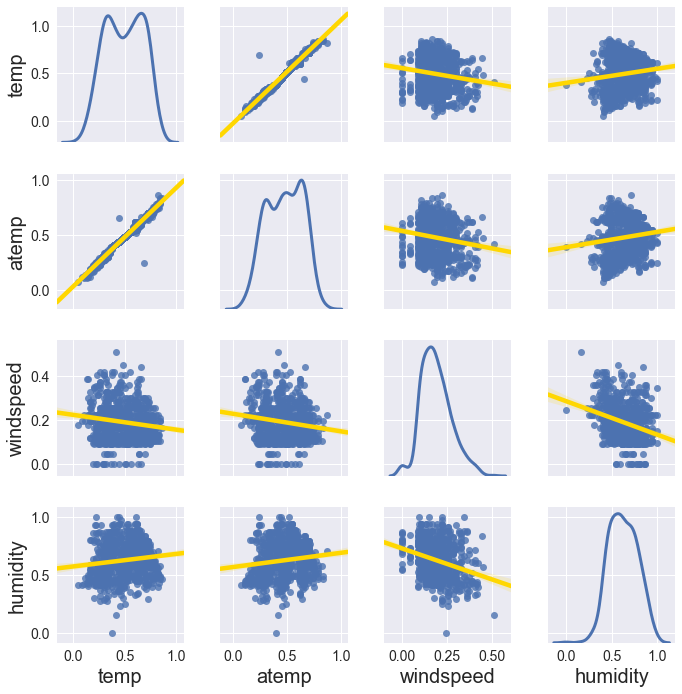

In [28]:
fig = sns.pairplot(dayta.loc[:,['temp','atemp','windspeed', 'humidity']], kind="reg", plot_kws={'line_kws':{'color':'gold'}}, diag_kind="kde")
plt.show()
fig.savefig('../reports/img/Q3WeatherPairPlotPerDay.jpg', bbox_inches='tight')

Unfortunately the windspeed and the humidity show no relationship with other factors that can be deduced at the simple eye.
However the temperature is highly correlated with the temperature felt. 

#### Correlation

In [29]:
# Hourly Data 
data.loc[:,['temp','atemp','windspeed','humidity']].corr().loc['atemp'].drop(['atemp'])

temp         0.99
windspeed   -0.07
humidity    -0.05
Name: atemp, dtype: float64

In [30]:
# Daily Data
dayta.corr().loc['atemp'].drop(['atemp'])

season               4.96e-02
year                 7.33e-03
month               -4.18e-02
holiday             -2.76e-02
dow                 -3.02e-03
workingday           4.62e-02
weather_condition   -1.51e-01
temp                 9.89e-01
windspeed           -1.60e-01
humidity             1.31e-01
casual               5.48e-01
registered           5.39e-01
cnt                  6.28e-01
nCasual              5.48e-01
nRegistered          5.39e-01
nCnt                 6.28e-01
Name: atemp, dtype: float64

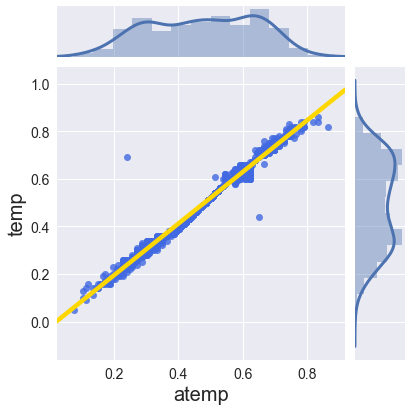

In [31]:
g1 = sns.JointGrid(x="atemp", y="temp", data=dayta) 
g1.plot_joint(sns.regplot, line_kws = {"color":"gold"}, color="royalblue") 
g1.plot_marginals(sns.distplot)
g1.savefig('../reports/img/Q3tempCorrelation.png', bbox_inches='tight')

stats models colinearity function

Could temp and atemp be colinear?? How to prove this? As for the question the temperature felt is not correlated with windspeed nor humidity at all.

Multicolinearity happens when 2 or more independent variables are added to create relations with the dependent variable and end up potentially related between each other.
The Ideal is for all independent variables to be correlated with the dependent variable but NOT with each other

## Regressions

In [32]:
mymodels = get_single_models_temp_atemp(dayta)

# Subset selection
dayta_weather = dayta.loc[:,['temp','atemp','windspeed', 'humidity']]
X = dayta_weather.reset_index()
X.drop(['date','atemp'],inplace=True, axis=1)
y = dayta.reset_index().atemp

mymodels = get_models(mymodels, X, y)
mymodels

Method   RSS  \
0      single_reg_with_temp  0.43   
1              mlr_all_vars  0.42   
2        mlr_temp_times_hum  0.42   
3           mlr_tmp_sq_temp  0.42   
4     Slow_Subset_selection  0.43   
5     Slow_Subset_selection  0.42   
6     Slow_Subset_selection  0.42   
7   Fwd_with_train_and_test  0.22   
8   Fwd_with_train_and_test  0.18   
9   Fwd_with_train_and_test  0.18   
10         Fwd_with_full_db  0.52   
11         Fwd_with_full_db  0.45   
12         Fwd_with_full_db  0.45   
13         Cross_Validation  0.03   
14         Cross_Validation  0.03   
15         Cross_Validation  0.03   

                                                model  
0   <statsmodels.regression.linear_model.Regressio...  
1   <statsmodels.regression.linear_model.Regressio...  
2   <statsmodels.regression.linear_model.Regressio...  
3   <statsmodels.regression.linear_model.Regressio...  
4   <statsmodels.regression.linear_model.Regressio...  
5   <statsmodels.regression.linear_model.Regressio...  
6   <statsmodels.regression.linear_model.Regressio...  
7   <statsmodels.regression.linear_model.Regressio...  
8   <statsmodels.regression.linear_model.Regressio...  
9   <statsmodels.regression.linear_model.Regressio...  
10  <statsmodels.regression.linear_model.Regressio...  
11  <statsmodels.regression.linear_model.Regressio...  
12  <statsmodels.regression.linear_model.Regressio...  
13  <statsmodels.regression.linear_model.Regressio...  
14  <statsmodels.regression.linear_model.Regressio...  
15  <statsmodels.regression.linear_model.Regressio...

### Results

In [33]:
best_models = pd.DataFrame(columns=["Method","RSS", "model"])

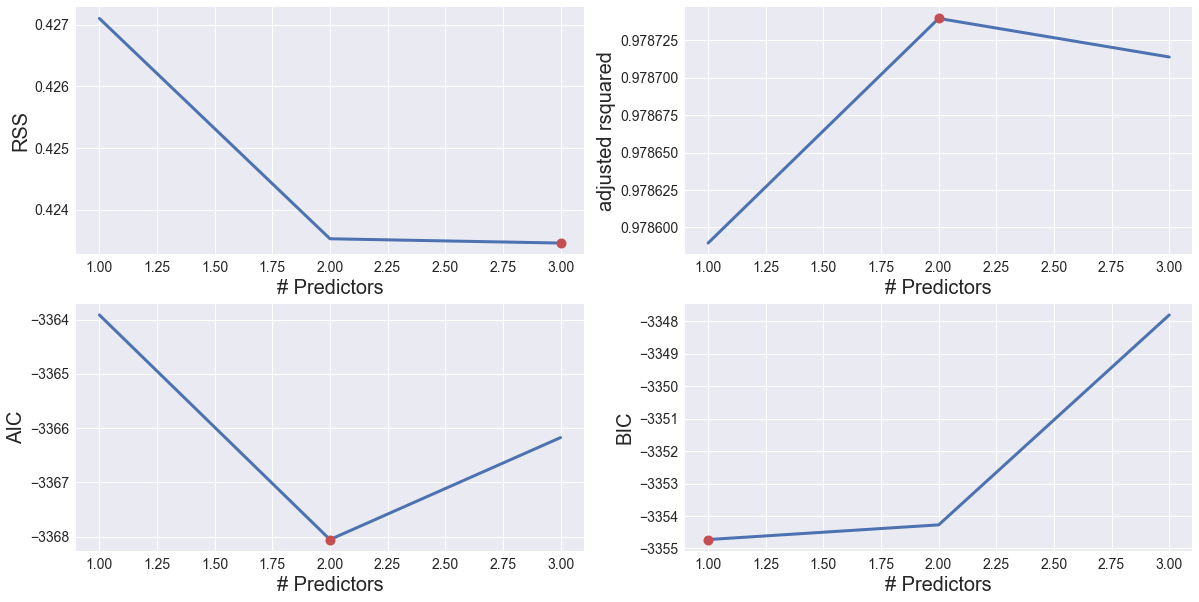

In [34]:
# Random subset Selection
models = mymodels.iloc[4:7,-2:].reset_index()
print_optimal_number_predictors(models)
fig.savefig('../reports/img/Q3RandomSubsetSlectionBestModelsResults.png', bbox_inches='tight')

The random subset selection method suggests 2 (temperature and windspeed) to 3 predictors

In [35]:
best_models.loc[0] = ['Randm Subset Selection', models.loc[2].RSS, models.loc[2].model]

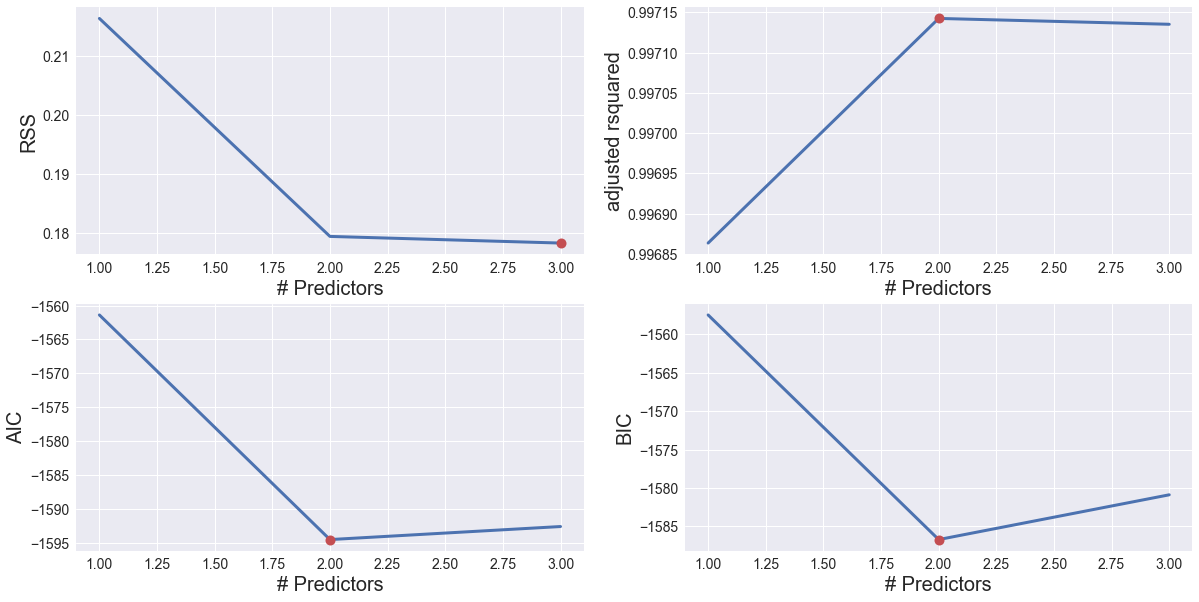

In [36]:
# FWD with train and test
models = mymodels.iloc[7:10,-2:].reset_index()
print_optimal_number_predictors(models)
fig.savefig('../reports/img/Q3FwdTrainTestSubsetSlectionBestModelsResults.png', bbox_inches='tight')

The forward subset selection method with training and test set suggests 2 (temperature and humidity)

In [37]:
best_models.loc[1] = ['Fwd subset slctn w train & test', models.loc[2].RSS, models.loc[2].model]

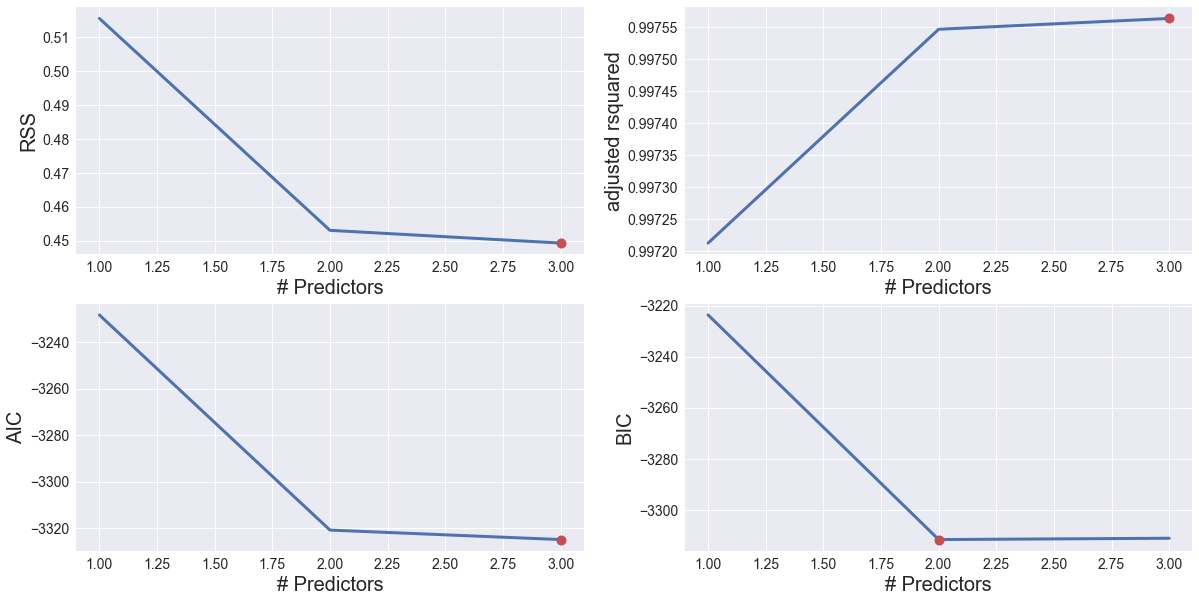

In [38]:
# Fwd_with_full_db
models = mymodels.iloc[10:13,-2:].reset_index()
print_optimal_number_predictors(models)
fig.savefig('../reports/img/Q3FwdFullDatasetSubsetSlectionBestModelsResults.png', bbox_inches='tight')

The full dataset forward selection method shows the model with 3 predictors as the best model. 

In [39]:
best_models.loc[2] = ['Fwd subset slctn w full db', models.loc[3].RSS, models.loc[3].model]
models.loc[3].model.params

temp         0.91
humidity     0.03
windspeed    0.02
dtype: float64

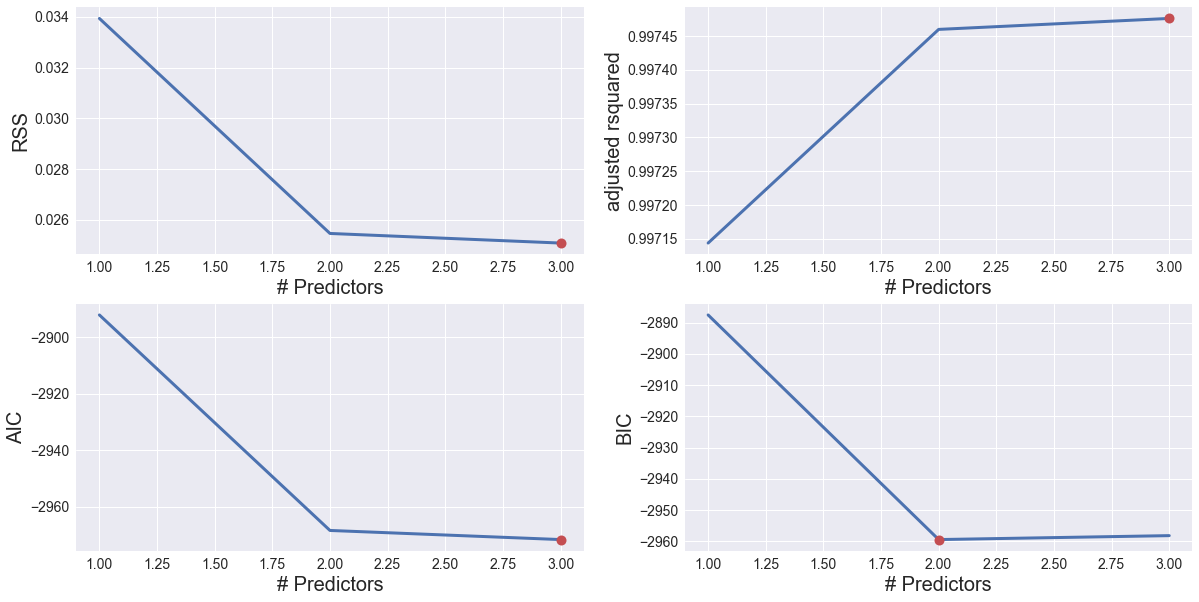

In [40]:
# Cross Validation
models = mymodels.iloc[13:16,-2:].reset_index()
fig = print_optimal_number_predictors(models)
fig.savefig('../reports/img/Q3CVBestModelsResults.png', bbox_inches='tight')

The Cross Validation method shows the model with 3 predictors as the best model. 

In [41]:
best_models.loc[3] = ['Cross Validation', models.loc[3].RSS, models.loc[3].model]
best_models

Method   RSS  \
0           Randm Subset Selection  0.42   
1  Fwd subset slctn w train & test  0.18   
2       Fwd subset slctn w full db  0.45   
3                 Cross Validation  0.03   

                                               model  
0  <statsmodels.regression.linear_model.Regressio...  
1  <statsmodels.regression.linear_model.Regressio...  
2  <statsmodels.regression.linear_model.Regressio...  
3  <statsmodels.regression.linear_model.Regressio...

Each method suggested that 2 to 3 predictors constituted the best prediction model for the temperature felt. 
Furthermore they all agree that the best single predictor is the temperature. Among the best models the Cross Validation method found the model with the least RSS. 

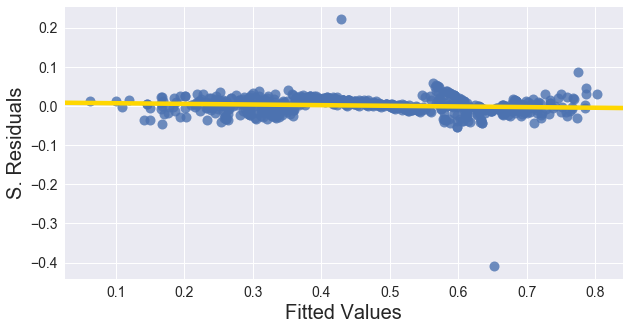

In [42]:
fitted_values = pd.Series(best_models.loc[3,'model'].fittedvalues, name="Fitted Values")
residuals = pd.Series(best_models.loc[3,'model'].resid, name="S. Residuals")
#s_residuals = pd.Series(mlr_all_var.resid_pearson, name="S. Residuals Normalized")
fig=plt.figure()
sns.regplot(fitted_values, residuals,  fit_reg=True, line_kws = {"color":"gold"})
plt.show()
fig.savefig('../reports/img/Q3ResidualPlot.png', bbox_inches='tight')

Residuals do not contradict the linear assumption. 
Lets see the quantile-quantile plot of the residuals:

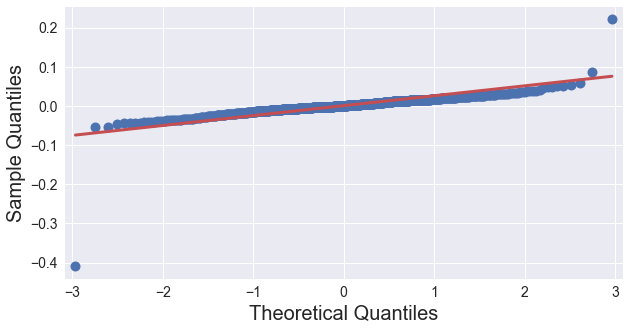

In [43]:
from statsmodels.api import qqplot
fig = qqplot(best_models.loc[3,'model'].resid, line='s')
plt.show()
fig.savefig('../reports/img/Q3CVBestModelsResults.png', bbox_inches='tight')

The residuals are approximately normally distributed making of the model a good fit. The zone of interest in the q-q plot is the middle so the extreme points in the sides can be ignored. 

In [44]:
best_models.loc[3].model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  atemp   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 8.695e+04
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        09:52:29   Log-Likelihood:                 1488.8
No. Observations:                 660   AIC:                            -2972.
Df Residuals:                     657   BIC:                            -2958.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.9117      0.005    183.553      0.000       0.902       0.921
humidity       0.0322      0.004      7.375      0.000       0.024       0.041
windspeed      0.0218      0.010      2.287      0.023       0.003       0.041
==============================================================================
Omnibus:                      808.352   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           344885.602
Skew:                          -5.434   Prob(JB):                         0.00
Kurtosis:                     114.459   Cond. No.                         8.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the summary above the temperature felt can be determined in terms of the temperature measured and humidity.

# Polynomials

In the figure below the temperature is plotted ranging from linear to a degree-5 polynomials. 

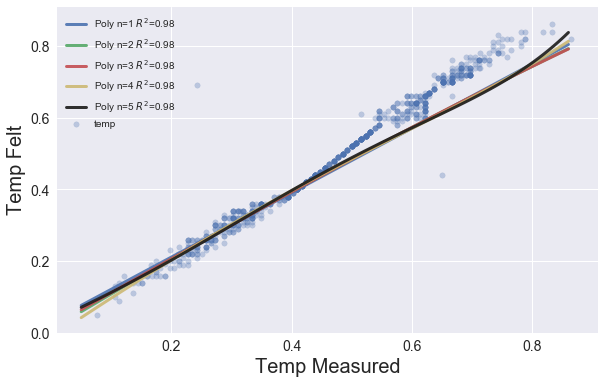

In [45]:
# plot lstat (% lower status of the population) against median value
plt.figure(figsize=(6 * 1.618, 6))
plt.scatter(dayta.atemp, dayta.temp, s=30, alpha=0.3)
plt.xlabel('Temp Measured')
plt.ylabel('Temp Felt')

# points linearlyd space on lstats
x = pd.DataFrame({'temp': np.linspace(dayta.temp.min(), dayta.temp.max(), 100)})

# 1-st order polynomial
poly_1 = smf.ols(formula='atemp ~ 1 + temp', data=dayta).fit()
plt.plot(x.temp, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared, 
         alpha=0.9)

# 2-nd order polynomial
poly_2 = smf.ols(formula='atemp ~ 1 + I(temp) + I(temp ** 2.0)', data=dayta).fit()
plt.plot(x.temp, poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % poly_2.rsquared, 
         alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='atemp ~ 1 + temp - I(temp ** 2.0) + I(temp ** 3.0)', data=dayta).fit()
plt.plot(x.temp, poly_3.predict(x), 'r-', alpha=0.9,
         label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

# 4-th order polynomial
poly_4 = smf.ols(formula='atemp ~ 1 + temp - I(temp ** 2.0) + I(temp ** 3.0) + I(temp ** 4.0)', data=dayta).fit()
plt.plot(x.temp, poly_4.predict(x), 'y-', alpha=0.9,
         label='Poly n=4 $R^2$=%.2f' % poly_4.rsquared)

# 5-th order polynomial
poly_5 = smf.ols(formula='atemp ~ 1 + I(temp) - I(temp ** 2.0) + I(temp ** 3.0) + I(temp ** 4.0) + I(temp ** 5.0)', data=dayta).fit()
plt.plot(x.temp, poly_5.predict(x), 'k-', alpha=0.9,
         label='Poly n=5 $R^2$=%.2f' % poly_5.rsquared)

plt.legend()
plt.show()
fig.savefig('../reports/img/Q3Polynomials.png', bbox_inches='tight')

In [46]:
print(sm.stats.anova_lm(poly_1, poly_2, poly_3, poly_4, poly_5, typ=1))

   df_resid   ssr  df_diff   ss_diff      F    Pr(>F)
0     729.0  0.43      0.0       NaN    NaN       NaN
1     728.0  0.42      1.0  8.98e-03  16.29  6.02e-05
2     728.0  0.42     -0.0 -1.76e-03    inf       NaN
3     727.0  0.41      1.0  1.03e-02  18.67  1.77e-05
4     726.0  0.40      1.0  9.42e-03  17.09  3.97e-05


The Anova test above shows that the 3rd degree polynomial p value is practically 0 suggesting that it is a good fit. 
However all of them are a good fit since they only differ from each other at the extreme values of the temperature where as the normal values of temperature will show pretty much the same result. 

## 4. How influential is the weather with both users? 
Will a nice day be more enticing to use the bike over a rainy day? Does the wind or temperature discourage people to take the bike?

Distribution of the demand according to every Hour:

In the figure below the total demand is displayed throughout the 2 years with a sampling period of a week. The demand seems to fluctuate in cycles, seasons and even has a positive trend. 

Visibly the temperature and the temperature felt have a strong correlation with the demand for bikes. 

Distribution of the demand according to each day:

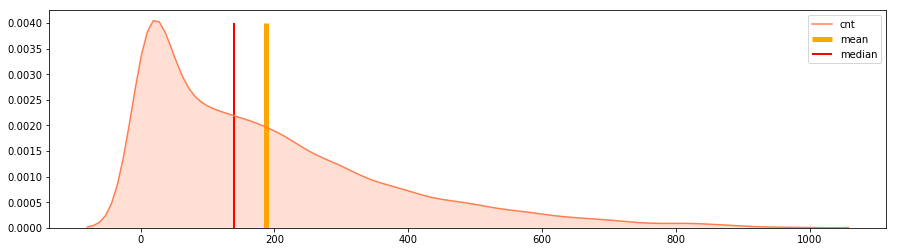

In [3]:
day_data = pd.DataFrame(data.loc[:,'cnt'])
get_distribution_with_center_metrics(day_data)

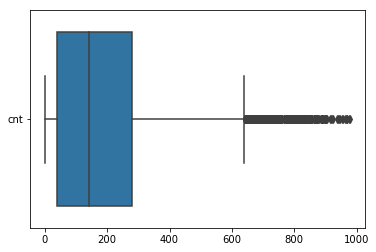

In [4]:
sns.boxplot(data=day_data, orient="h")
plt.show()

*Looks like the demand from every day will be better represented by its distribution's median. Or should there be a* ***log transformation??***

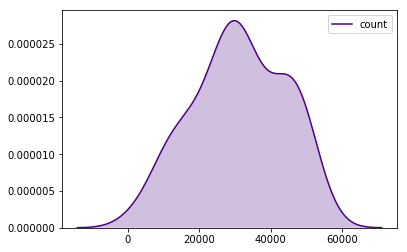

In [5]:
sns.kdeplot(week_data.cnt, shade=True, color="indigo", label='count')

Normalizing the count by week, yields a somewhat normal distribution

In [6]:
print('Skew',week_data.nCnt.skew(),'Kurtosis',week_data.nCnt.kurt())

Skew -0.185194550595 Kurtosis -0.773865114957


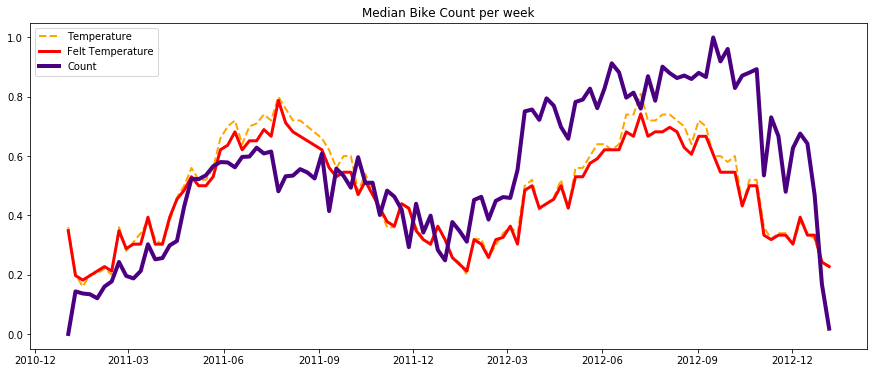

In [7]:
# multiple line plot to compare the temperature with the count
plt.figure(figsize=(15,6))
plt.plot(week_data.index.values, week_data.temp, color='orange', linewidth=2, linestyle='dashed',label='Temperature')
plt.plot(week_data.index.values, week_data.atemp, color='red', linewidth=3, label='Felt Temperature')
plt.plot(week_data.index.values, week_data.nCnt, color='indigo', linewidth=4, label='Count')
plt.title('Median Bike Count per week')
plt.legend()

The count seems to correlate with the temperature and the feels-like temperature. During the 2 years the cycles of the temperature agree with those of the count. 

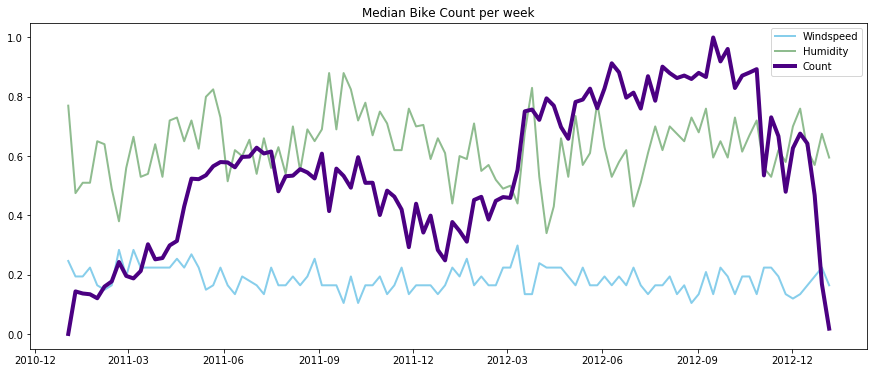

In [8]:
plt.figure(figsize=(15,6))
plt.plot(week_data.index.values, week_data.windspeed, color='skyblue', linewidth=2, label='Windspeed')
plt.plot(week_data.index.values, week_data.humidity, color='darkseagreen', linewidth=2, label='Humidity')
plt.plot(week_data.index.values, week_data.nCnt, color='indigo', linewidth=4, label='Count')
plt.title('Median Bike Count per week')
plt.legend()

It can be seen that almost every negative change in humidity there is an opposite change in demand...
#### *Simple linear regression with **count** as the response and **temperature felt** as the predictor.*

In [9]:
result = sm.OLS.from_formula('nCnt ~ atemp', dayta).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     474.4
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           2.13e-81
Time:                        09:58:05   Log-Likelihood:                 209.94
No. Observations:                 731   AIC:                            -415.9
Df Residuals:                     729   BIC:                            -406.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0703      0.020      3.435      0.001       0.030       0.111
atemp          0.8860      0.041     21.780      0.000       0.806       0.966
==============================================================================
Omnibus:                        7.017   Durbin-Watson:                   0.484
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                5.568
Skew:                           0.116   Prob(JB):                       0.0618
Kurtosis:                       2.641   Cond. No.                         7.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
reg_result = pd.DataFrame({'simple reg with atemp':[result.rsquared, result.fvalue, result.aic, result.bic, [result.pvalues]]}).T
reg_result.columns = ['R','f','AIC','BIC', 'p_values']
reg_result

R        f      AIC      BIC  \
simple reg with atemp  0.39  4.7e+02 -4.2e+02 -4.1e+02   

                                                                p_values  
simple reg with atemp  [[0.0006259666151590065, 2.1318914941261025e-81]]

***The R2 is 39% which is not bad and the p values are almost 0, is it necessary to have an intercept tho?***

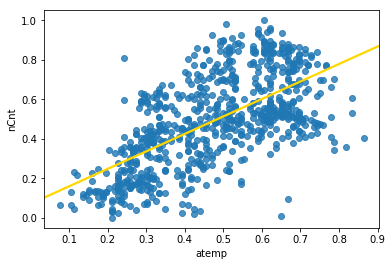

In [11]:
sns.regplot('atemp', 'nCnt', dayta, line_kws = {"color":"gold"}, ci=None)

The temperature felt and the bike demand relationship accounts for **38%** of the variation. 

## What is the predicted number of bikes when theres a temperature that feels like 26C

In [12]:
t = 26
t_min=-16
t_max=50
t_norm = (t-t_min)/(t_max-t_min)
r = result.params['Intercept'] + result.params['atemp'] * t_norm
print('For a temperature of',t,'Celsius (',t_norm,'), the number of bikes out there is ',int(max(week_data.cnt)*r),'(',r,')')

For a temperature of 26 Celsius ( 0.6363636363636364 ), the number of bikes out there is  34893 ( 0.634174655771 )


## What is the predicted number of bikes when theres a temperature that feels like 25C, 30C and 35C

In [13]:
new = pd.DataFrame([[1, 25], [1, 30], [1, 35]], columns=['Intercept', 'atemp'])
# Normalize atemp
t_min=-16
t_max=50
new.atemp = (new.atemp-t_min)/(t_max-t_min)
p = predict(result, new)
# Denormalize
p.fit = p.fit*int(max(dayta.cnt))
p.lower = p.lower*int(max(dayta.cnt))
p.upper = p.upper*int(max(dayta.cnt))
p

fit    lower    upper
0  5409.22  4626.57  6191.86
1  5994.13  5158.76  6829.49
2  6579.03  5690.95  7467.12

### Residuals and qq plots

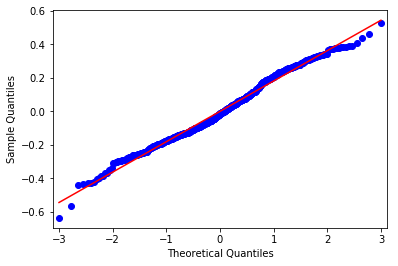

In [14]:
qqplot(result.resid, line='s')
plt.show()

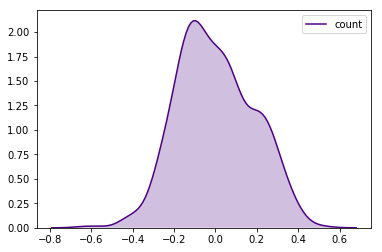

In [15]:
sns.kdeplot(result.resid, shade=True, color="indigo", label='count')

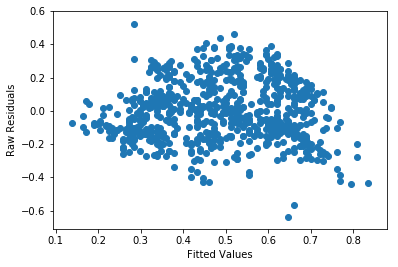

In [16]:
plt.figsize=(18,10)
plt.scatter(result.fittedvalues, result.resid)
plt.ylabel('Raw Residuals')
plt.xlabel('Fitted Values')
plt.show()

The error terms are assumed to be normally distributed, Homoscedastic and Independent!

The residual plot shows that the regression line is good at explaining the relationship between the temperature felt and the demand in bikes. 

The residuals do not contradict the linear assumption

# multiple linear regression:

In [17]:
model = sm.OLS.from_formula('nCnt ~ atemp + temp', dayta)
mlr_temp_atemp = model.fit()
# Add the results to the results dataframe: 
reg_result.loc['mult reg with atemp and temp'] = [mlr_temp_atemp.rsquared, mlr_temp_atemp.fvalue, mlr_temp_atemp.aic, mlr_temp_atemp.bic, [mlr_temp_atemp.pvalues]]

# All columns (except nCnt, which is our response)
model = sm.OLS.from_formula('nCnt ~ temp + atemp + windspeed + humidity', dayta)
mlr_all_var = model.fit()
reg_result.loc['mult reg with all vars'] = [mlr_all_var.rsquared, mlr_all_var.fvalue, mlr_all_var.aic, mlr_all_var.bic, [mlr_all_var.pvalues]]

model = sm.OLS.from_formula('nCnt ~ temp * atemp', dayta)
mlr_tmp_times_atmp = model.fit()
reg_result.loc['mult reg with temp*atemp'] = [mlr_tmp_times_atmp.rsquared, mlr_tmp_times_atmp.fvalue, mlr_tmp_times_atmp.aic, mlr_tmp_times_atmp.bic, [mlr_tmp_times_atmp.pvalues]]

model = sm.OLS.from_formula('nCnt ~ atemp + np.square(atemp)', dayta)
mlr_atmp_sq_atemp = model.fit()
reg_result.loc['mult reg with square(atemp)'] = [mlr_atmp_sq_atemp.rsquared, mlr_atmp_sq_atemp.fvalue, mlr_atmp_sq_atemp.aic, mlr_atmp_sq_atemp.bic, [mlr_atmp_sq_atemp.pvalues]]
reg_result

R        f      AIC      BIC  \
simple reg with atemp         0.39  4.7e+02 -4.2e+02 -4.1e+02   
mult reg with atemp and temp   0.4  2.4e+02 -4.2e+02   -4e+02   
mult reg with all vars        0.45  1.5e+02 -4.9e+02 -4.6e+02   
mult reg with temp*atemp      0.45    2e+02 -4.8e+02 -4.6e+02   
mult reg with square(atemp)   0.44  2.9e+02 -4.7e+02 -4.6e+02   

                                                                       p_values  
simple reg with atemp         [[0.0006259666151590065, 2.1318914941261025e-81]]  
mult reg with atemp and temp  [[0.0002568118513482815, 0.06182579673327824, ...  
mult reg with all vars        [[1.1743082723004402e-20, 0.08270556818893149,...  
mult reg with temp*atemp      [[1.2087756758239005e-08, 1.1867565450834777e-...  
mult reg with square(atemp)   [[1.4137964665723383e-08, 8.181786376880045e-2...

***The 3rd model shows the highest fiting potential however this model takes into account all the variables thus a chance of overfitting. Below, the residuals plot is not very convincing at showing a normal distribution as the variance increases with higher predicted values.***

In [18]:
mlr_all_var.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     151.4
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           3.81e-94
Time:                        09:59:18   Log-Likelihood:                 248.48
No. Observations:                 731   AIC:                            -487.0
Df Residuals:                     726   BIC:                            -464.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3871      0.040      9.608      0.000       0.308       0.466
temp           0.4183      0.241      1.738      0.083      -0.054       0.891
atemp          0.4257      0.266      1.603      0.109      -0.096       0.947
windspeed     -0.5486      0.081     -6.736      0.000      -0.708      -0.389
humidity      -0.3188      0.043     -7.386      0.000      -0.404      -0.234
==============================================================================
Omnibus:                       10.052   Durbin-Watson:                   0.429
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                7.592
Skew:                           0.144   Prob(JB):                       0.0225
Kurtosis:                       2.592   Cond. No.                         77.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

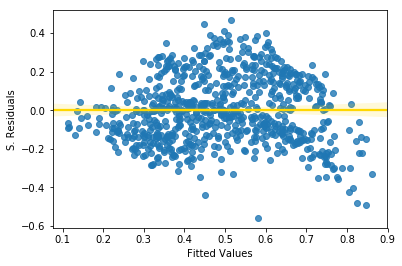

In [19]:
fitted_values = pd.Series(mlr_all_var.fittedvalues, name="Fitted Values")
residuals = pd.Series(mlr_all_var.resid, name="S. Residuals")
#s_residuals = pd.Series(mlr_all_var.resid_pearson, name="S. Residuals Normalized")
sns.regplot(fitted_values, residuals,  fit_reg=True, line_kws = {"color":"gold"})

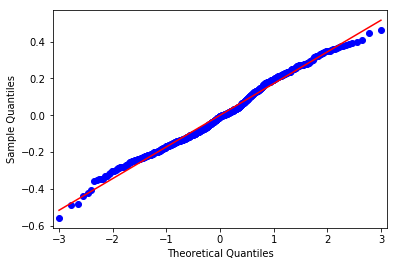

In [20]:
qqplot(mlr_all_var.resid, line='s')
plt.show()

The qqplot above shows that multiple regression with all variables present a somewhat normal distribution

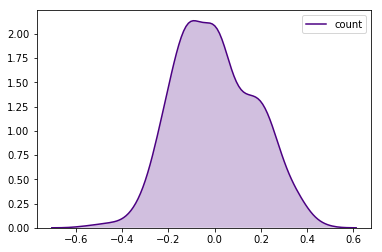

In [21]:
sns.kdeplot(mlr_all_var.resid, shade=True, color="indigo", label='count')

***The 4th and 5th models show promising Rsquared values***

In [22]:
mlr_tmp_times_atmp.rsquared

0.4467884126868783

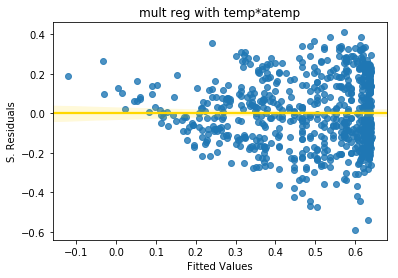

In [23]:
fitted_values = pd.Series(mlr_tmp_times_atmp.fittedvalues, name="Fitted Values")
residuals = pd.Series(mlr_tmp_times_atmp.resid, name="S. Residuals")
#s_residuals = pd.Series(mlr_all_var.resid_pearson, name="S. Residuals Normalized")
sns.regplot(fitted_values, residuals,  fit_reg=True, line_kws = {"color":"gold"})
plt.title('mult reg with temp*atemp')
plt.show()

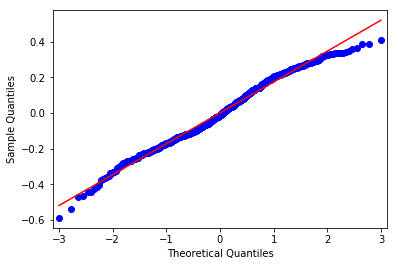

In [24]:
qqplot(mlr_tmp_times_atmp.resid, line='s')
plt.show()

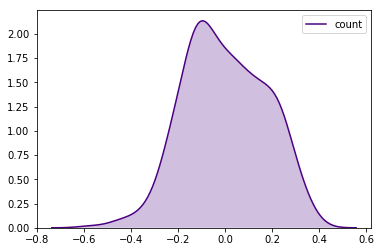

In [25]:
sns.kdeplot(mlr_tmp_times_atmp.resid, shade=True, color="indigo", label='count')

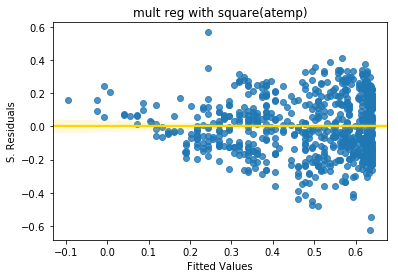

In [26]:
fitted_values = pd.Series(mlr_atmp_sq_atemp.fittedvalues, name="Fitted Values")
residuals = pd.Series(mlr_atmp_sq_atemp.resid, name="S. Residuals")
#s_residuals = pd.Series(mlr_all_var.resid_pearson, name="S. Residuals Normalized")
sns.regplot(fitted_values, residuals,  fit_reg=True, line_kws = {"color":"gold"})
plt.title('mult reg with square(atemp)')

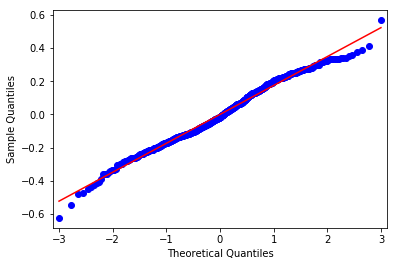

In [27]:
qqplot(mlr_atmp_sq_atemp.resid, line='s')
plt.show()

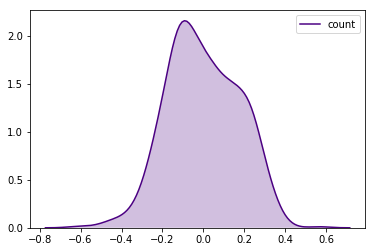

In [28]:
sns.kdeplot(mlr_atmp_sq_atemp.resid, shade=True, color="indigo", label='count')

None of the models above show an adequate fit as their residual plots dont assume a normal distribution, homoscedatic and 

### Subset Selection

In [30]:
mymodels = get_single_models_nCnt_atemp(dayta)

# Subset selection
X = dayta.reset_index().iloc[:,[8,9,10,11]]
y = dayta.reset_index().nCnt

mymodels = get_models(mymodels,X,y)
mymodels

Method    RSS  \
0      single_reg_with_temp  24.10   
1              mlr_all_vars  21.69   
2        mlr_temp_times_hum    NaN   
3           mlr_tmp_sq_temp    NaN   
4     Slow_Subset_selection  24.10   
5     Slow_Subset_selection  23.09   
6     Slow_Subset_selection  21.76   
7     Slow_Subset_selection  21.69   
8   Fwd_with_train_and_test  13.05   
9   Fwd_with_train_and_test  13.03   
10  Fwd_with_train_and_test  13.04   
11  Fwd_with_train_and_test  13.08   
12         Fwd_with_full_db  24.49   
13         Fwd_with_full_db  24.45   
14         Fwd_with_full_db  24.44   
15         Fwd_with_full_db  24.44   
16         Cross_Validation   2.46   
17         Cross_Validation   2.44   
18         Cross_Validation   2.43   
19         Cross_Validation   2.45   

                                                model  
0   <statsmodels.regression.linear_model.Regressio...  
1   <statsmodels.regression.linear_model.Regressio...  
2   <statsmodels.regression.linear_model.Regressio...  
3   <statsmodels.regression.linear_model.Regressio...  
4   <statsmodels.regression.linear_model.Regressio...  
5   <statsmodels.regression.linear_model.Regressio...  
6   <statsmodels.regression.linear_model.Regressio...  
7   <statsmodels.regression.linear_model.Regressio...  
8   <statsmodels.regression.linear_model.Regressio...  
9   <statsmodels.regression.linear_model.Regressio...  
10  <statsmodels.regression.linear_model.Regressio...  
11  <statsmodels.regression.linear_model.Regressio...  
12  <statsmodels.regression.linear_model.Regressio...  
13  <statsmodels.regression.linear_model.Regressio...  
14  <statsmodels.regression.linear_model.Regressio...  
15  <statsmodels.regression.linear_model.Regressio...  
16  <statsmodels.regression.linear_model.Regressio...  
17  <statsmodels.regression.linear_model.Regressio...  
18  <statsmodels.regression.linear_model.Regressio...  
19  <statsmodels.regression.linear_model.Regressio...

Graph every model for each method showing the RSS, adjusted R squared, BIC and AIC and visually pick the best model

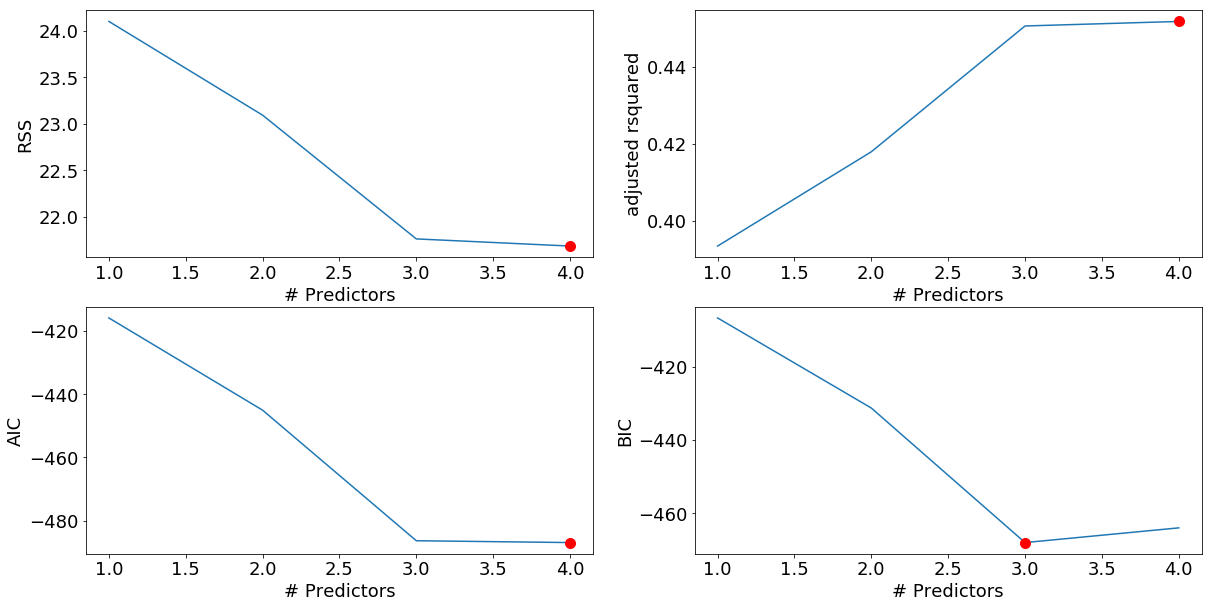

In [56]:
best_models = pd.DataFrame(columns=["Method","RSS", "model"])
# Random subset Selection
models = mymodels.iloc[4:8,-2:].reset_index()
fig = print_optimal_number_predictors(models)
#fig.savefig('BestNoPredictors.png', bbox_inches='tight')

3 or 4 predictors seem to describe the best model

In [32]:
models.loc[3,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     200.6
Date:                Thu, 19 Jul 2018   Prob (F-statistic):           8.87e-95
Time:                        15:58:12   Log-Likelihood:                 247.19
No. Observations:                 731   AIC:                            -486.4
Df Residuals:                     727   BIC:                            -468.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4026      0.039     10.283      0.000       0.326       0.479
temp           0.7998      0.036     22.412      0.000       0.730       0.870
windspeed     -0.5596      0.081     -6.888      0.000      -0.719      -0.400
humidity      -0.3179      0.043     -7.358      0.000      -0.403      -0.233
==============================================================================
Omnibus:                       13.535   Durbin-Watson:                   0.418
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                9.928
Skew:                           0.176   Prob(JB):                      0.00698
Kurtosis:                       2.550   Cond. No.                         17.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It's surprising that atemp is not the best model for 3 predictors!

In [57]:
best_models.loc[0] = ['Randm Subset Selection', models.loc[3].RSS, models.loc[3].model]

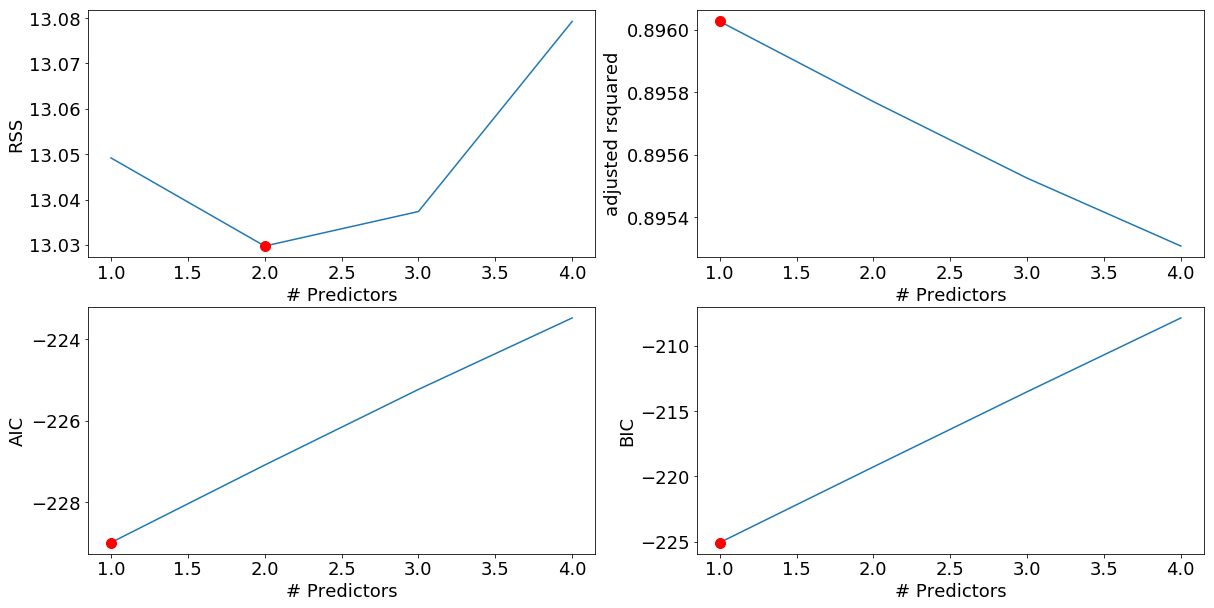

In [58]:
# FWD with train and test
models = mymodels.iloc[8:12,-2:].reset_index()
fig = print_optimal_number_predictors(models)
#fig.savefig('BestNoPredictors.png', bbox_inches='tight')

In [36]:
# 1 or 2 predictors
models.loc[2,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     1578.
Date:                Thu, 19 Jul 2018   Prob (F-statistic):          2.24e-180
Time:                        15:59:16   Log-Likelihood:                 115.54
No. Observations:                 367   AIC:                            -227.1
Df Residuals:                     365   BIC:                            -219.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
atemp          1.0187      0.033     31.055      0.000       0.954       1.083
windspeed     -0.0256      0.081     -0.315      0.753      -0.185       0.134
==============================================================================
Omnibus:                        2.643   Durbin-Watson:                   0.554
Prob(Omnibus):                  0.267   Jarque-Bera (JB):                2.303
Skew:                           0.096   Prob(JB):                        0.316
Kurtosis:                       2.662   Cond. No.                         5.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

However the p value for the 2-predictor model is not significantly low for the windspeed variable

In [59]:
best_models.loc[1] = ['Fwd subset slctn w train & test', models.loc[1].RSS, models.loc[1].model]

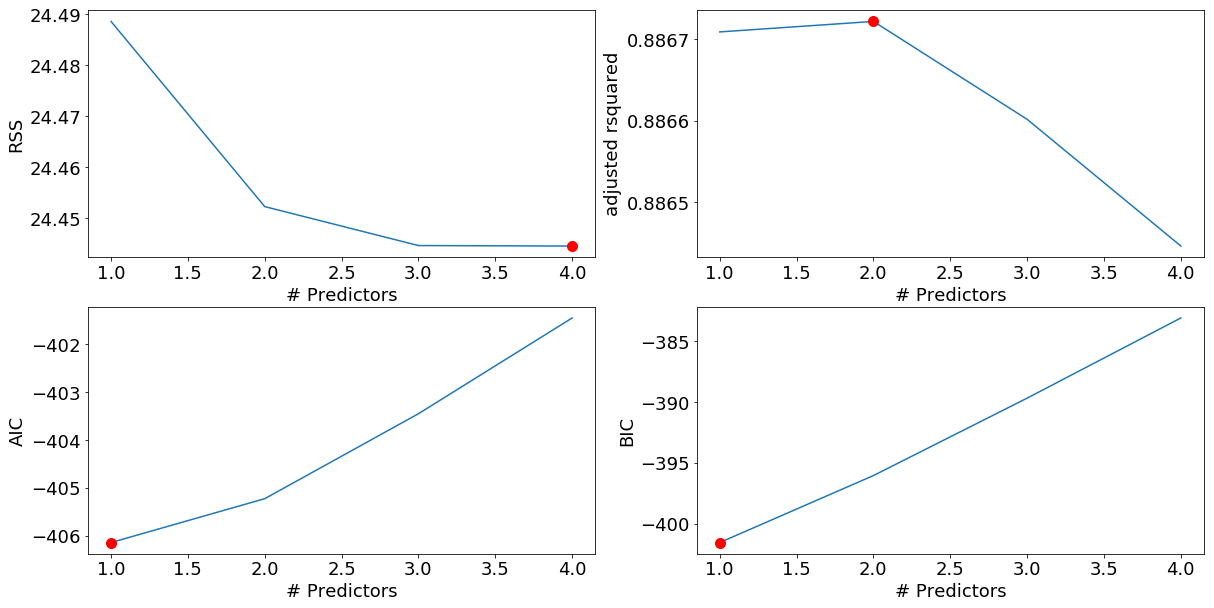

In [61]:
# Fwd_with_full_db
models = mymodels.iloc[12:16,-2:].reset_index()
fig = print_optimal_number_predictors(models)
#fig.savefig('BestNoPredictors.png', bbox_inches='tight')

In [62]:
# 1 predictor
models.loc[2,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     2862.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        10:24:27   Log-Likelihood:                 204.61
No. Observations:                 731   AIC:                            -405.2
Df Residuals:                     729   BIC:                            -396.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
atemp          1.0402      0.025     41.294      0.000       0.991       1.090
windspeed     -0.0635      0.061     -1.041      0.298      -0.183       0.056
==============================================================================
Omnibus:                        1.720   Durbin-Watson:                   0.492
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.631
Skew:                           0.035   Prob(JB):                        0.442
Kurtosis:                       2.779   Cond. No.                         5.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
best_models.loc[2] = ['Fwd subset slctn w full db', models.loc[1].RSS, models.loc[1].model]

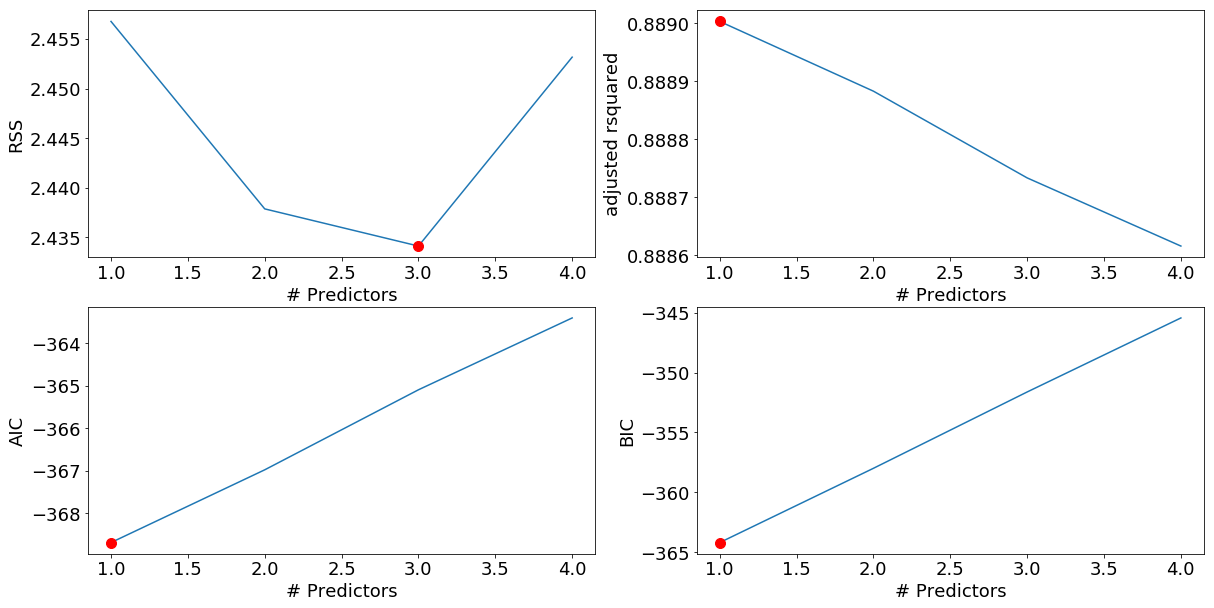

In [68]:
# Cross Validation
models = mymodels.iloc[16:20,-2:].reset_index()
fig = print_optimal_number_predictors(models)
fig.savefig('../reports/img/Q4CVBestNoPredictors.png', bbox_inches='tight')

In [69]:
# 1 or 3
models.loc[1,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     5287.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):          5.37e-317
Time:                        10:28:33   Log-Likelihood:                 185.35
No. Observations:                 660   AIC:                            -368.7
Df Residuals:                     659   BIC:                            -364.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
atemp          1.0231      0.014     72.713      0.000       0.996       1.051
==============================================================================
Omnibus:                        3.085   Durbin-Watson:                   0.488
Prob(Omnibus):                  0.214   Jarque-Bera (JB):                2.694
Skew:                           0.069   Prob(JB):                        0.260
Kurtosis:                       2.719   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
best_models.loc[3] = ['Cross Validation', models.loc[1].RSS, models.loc[1].model]
best_models

Method    RSS  \
0           Randm Subset Selection  21.76   
1  Fwd subset slctn w train & test  13.05   
2       Fwd subset slctn w full db  24.49   
3                 Cross Validation   2.46   

                                               model  
0  <statsmodels.regression.linear_model.Regressio...  
1  <statsmodels.regression.linear_model.Regressio...  
2  <statsmodels.regression.linear_model.Regressio...  
3  <statsmodels.regression.linear_model.Regressio...

Cross validation is the best method to choose a model that has comparably lower values of RSS and in this case the best model is the single predictor one. **Temperature felt is the best predictor.** 

In [73]:
best_models.loc[3].model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     5287.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):          5.37e-317
Time:                        10:34:49   Log-Likelihood:                 185.35
No. Observations:                 660   AIC:                            -368.7
Df Residuals:                     659   BIC:                            -364.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
atemp          1.0231      0.014     72.713      0.000       0.996       1.051
==============================================================================
Omnibus:                        3.085   Durbin-Watson:                   0.488
Prob(Omnibus):                  0.214   Jarque-Bera (JB):                2.694
Skew:                           0.069   Prob(JB):                        0.260
Kurtosis:                       2.719   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

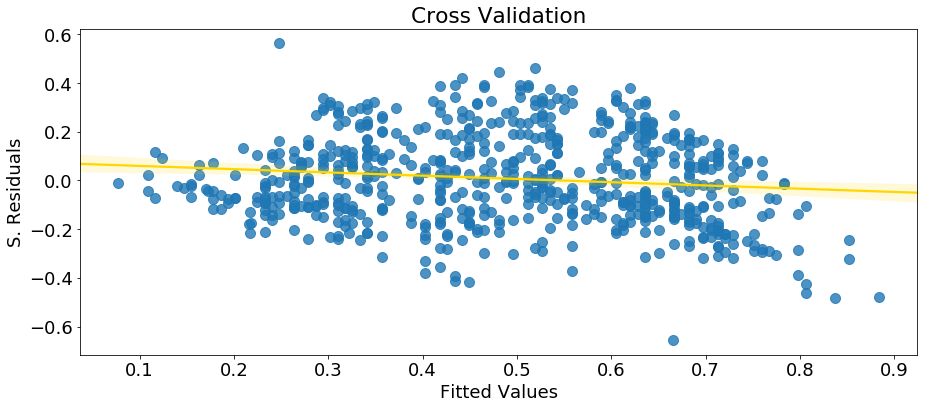

In [77]:
fig = plt.figure(figsize=(15,6))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})
fitted_values = pd.Series(best_models.loc[3,'model'].fittedvalues, name="Fitted Values")
residuals = pd.Series(best_models.loc[3,'model'].resid, name="S. Residuals")
sns.regplot(fitted_values, residuals,  fit_reg=True, line_kws = {"color":"gold"})
plt.title(best_models.loc[3,'Method'])
plt.show()
fig.savefig('../reports/img/Q4CVResidualPlot.png', bbox_inches='tight')

It's fair to say that from the figure above there's little variance on the high and low predicted values. 

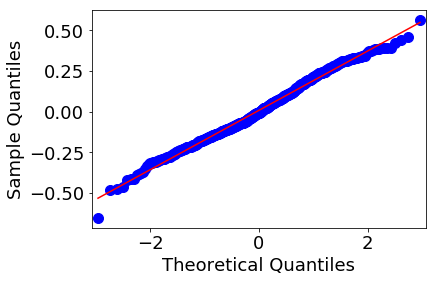

In [80]:
fig = plt.figure(figsize=(15,6))
fig = qqplot(best_models.loc[3,'model'].resid, line='s')
plt.show()
fig.savefig('../reports/img/Q4CVqqPlot.png', bbox_inches='tight')

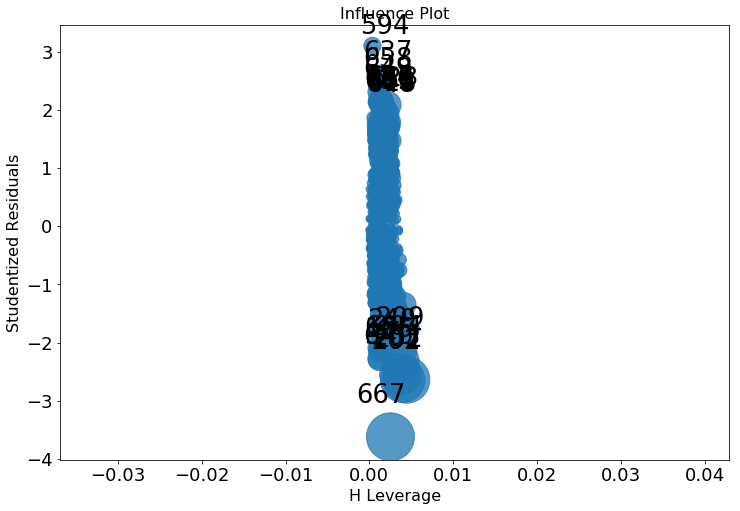

In [46]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(best_models.loc[3,'model'],ax=ax)

# Polynomials

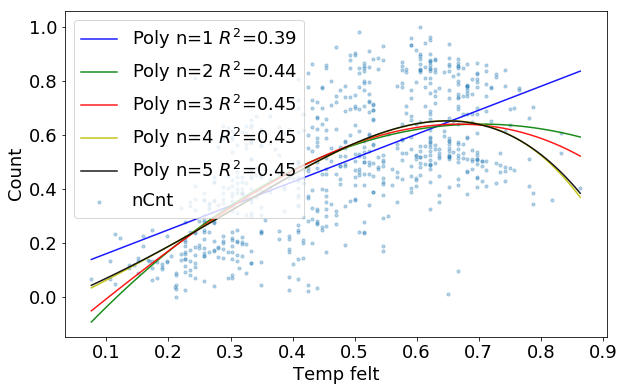

In [83]:
# plot lstat (% lower status of the population) against median value
fig = plt.figure(figsize=(6 * 1.618, 6))
plt.scatter(dayta.atemp, dayta.nCnt, s=10, alpha=0.3)
plt.xlabel('Temp felt')
plt.ylabel('Count')

# points linearlyd space on lstats
x = pd.DataFrame({'atemp': np.linspace(dayta.atemp.min(), dayta.atemp.max(), 100)})

# 1-st order polynomial
poly_1 = smf.ols(formula='nCnt ~ 1 + atemp', data=dayta).fit()
plt.plot(x.atemp, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared, 
         alpha=0.9)

# 2-nd order polynomial
poly_2 = smf.ols(formula='nCnt ~ 1 + I(atemp) + I(atemp ** 2.0)', data=dayta).fit()
plt.plot(x.atemp, poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % poly_2.rsquared, 
         alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='nCnt ~ 1 + atemp - I(atemp ** 2.0) + I(atemp ** 3.0)', data=dayta).fit()
plt.plot(x.atemp, poly_3.predict(x), 'r-', alpha=0.9,
         label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

# 4-th order polynomial
poly_4 = smf.ols(formula='nCnt ~ 1 + atemp - I(atemp ** 2.0) + I(atemp ** 3.0) + I(atemp ** 4.0)', data=dayta).fit()
plt.plot(x.atemp, poly_4.predict(x), 'y-', alpha=0.9,
         label='Poly n=4 $R^2$=%.2f' % poly_4.rsquared)

# 5-th order polynomial
poly_5 = smf.ols(formula='nCnt ~ 1 + I(atemp) - I(atemp ** 2.0) + I(atemp ** 3.0) + I(atemp ** 4.0) + I(atemp ** 5.0)', data=dayta).fit()
plt.plot(x.atemp, poly_5.predict(x), 'k-', alpha=0.9,
         label='Poly n=5 $R^2$=%.2f' % poly_5.rsquared)

plt.legend()
plt.show()
fig.savefig('../reports/img/Q4Polynomials.png', bbox_inches='tight')

In [48]:
print(sm.stats.anova_lm(poly_1, poly_2, poly_3, poly_4, poly_5, typ=1))

   df_resid    ssr  df_diff   ss_diff      F    Pr(>F)
0     729.0  24.10      0.0       NaN    NaN       NaN
1     728.0  22.23      1.0  1.87e+00  62.13  1.18e-14
2     728.0  22.02     -0.0  2.15e-01   -inf       NaN
3     727.0  21.82      1.0  1.96e-01   6.52  1.09e-02
4     726.0  21.82      1.0  1.44e-03   0.05  8.27e-01


The p value from model 3 and 4 is the highest suggesting either model is a better fit than the rest. 

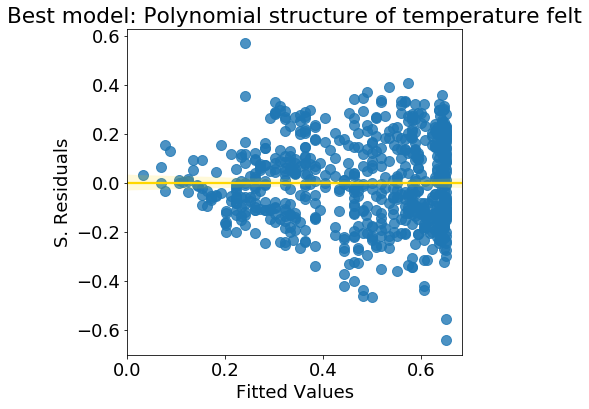

In [49]:
fig = plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})
fitted_values = pd.Series(poly_4.fittedvalues, name="Fitted Values")
residuals = pd.Series(poly_4.resid, name="S. Residuals")
sns.regplot(fitted_values, residuals,  fit_reg=True, line_kws = {"color":"gold"})
plt.title('Best model: Polynomial structure of temperature felt')
plt.show()

fig.savefig('Q4CVBestModelsResults.png', bbox_inches='tight')

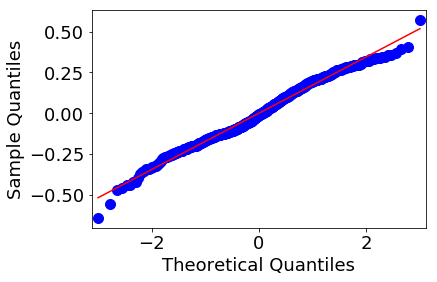

In [50]:
fig = plt.figure(figsize=(10,6))
qqplot(poly_4.resid, line='s')
plt.show()

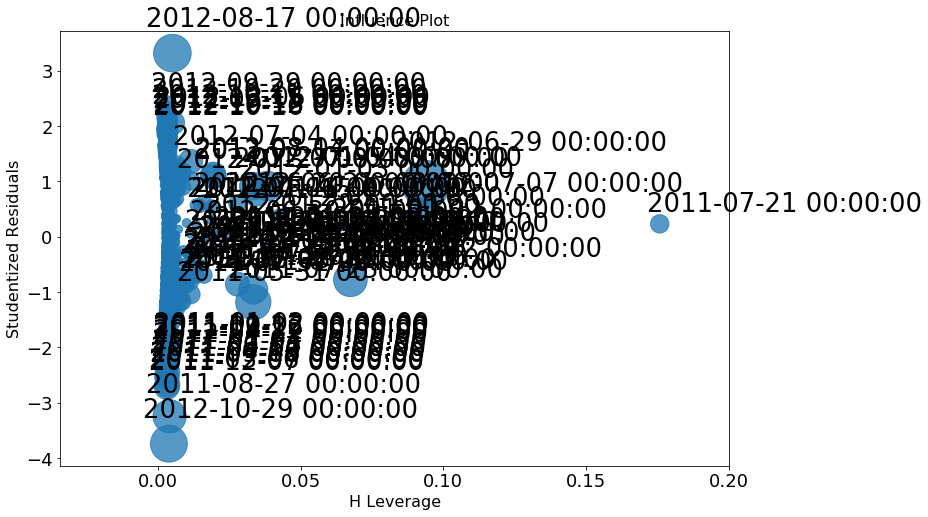

In [51]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(poly_4,ax=ax)

## 5. In any normal day, is there a pattern of the usage over the course of time? Can we predict the count of bikers given the time, day and weather?

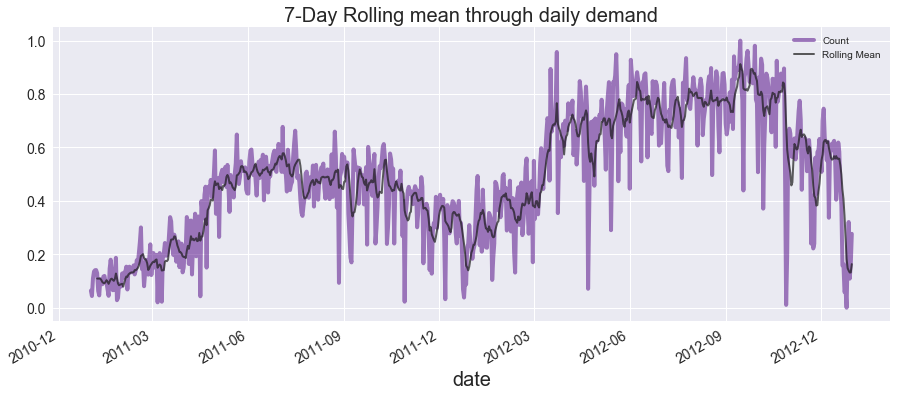

In [50]:
fig = plt.figure(figsize=(15,6))
plt.plot(dayta.index.values, dayta.nCnt, color='indigo', linewidth=4, label='Count',alpha=0.5)
dayta.nCnt.rolling(window=7).mean().plot(style=['k'],linewidth=2, label='Rolling Mean', alpha=0.7)
plt.title('7-Day Rolling mean through daily demand')
plt.grid('on')
plt.legend()
plt.show()
fig.savefig('../reports/img/Q57DayRollingMean.png', bbox_inches='tight')

I will use the weekly-average to reduce the seasonality and trend of the above signal. Then the demand will go through a smoothing process of 2 days average. 

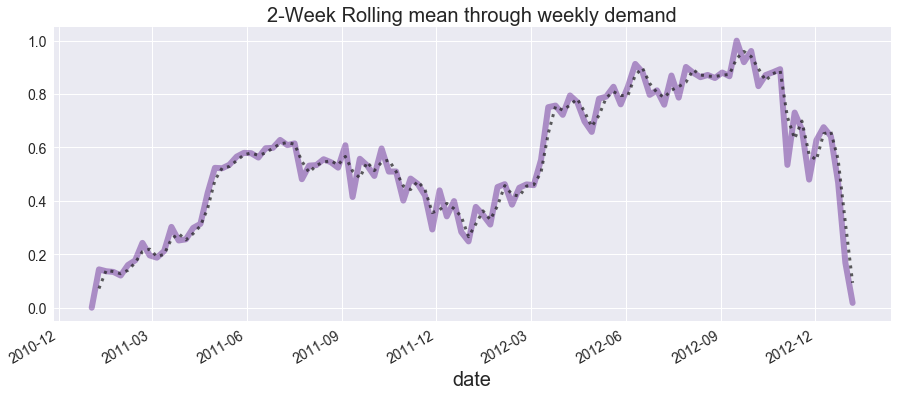

In [51]:
week_data['smoothed'] = week_data.nCnt.rolling(window=2).mean()

plt.figure(figsize=(15,6))
plt.plot(week_data.index.values, week_data.nCnt, color='indigo', linewidth=6, label='Count', alpha=0.4)
week_data.nCnt.rolling(window=2).mean().plot(style=['k:'],linewidth=3, alpha=0.7)
plt.title('2-Week Rolling mean through weekly demand')
plt.grid('on')
plt.show()

In [52]:
week_data.set_value('2011-01-02', 'smoothed', 0)   # Fill in the Smoothed out value
week_data.head(2)

season  year  weather_condition  temp  atemp  windspeed  humidity  \
date                                                                            
2011-01-02       1  2011                2.0  0.36   0.35       0.25      0.77   
2011-01-09       1  2011                1.0  0.20   0.20       0.19      0.47   

            casual  registered   cnt   nCasual  nRegistered  nCnt  smoothed  
date                                                                         
2011-01-02     460        1312  1772  1.80e-03         0.00  0.00      0.00  
2011-01-09     668        8747  9415  1.96e-02         0.17  0.14      0.07

In [53]:
# keep only useful columns
df_week = week_data.loc[:, ['season','atemp','nCnt','smoothed']]
df_week = pd.get_dummies(df_week, columns=['season'])
df_week.head()

atemp  nCnt  smoothed  season_1  season_2  season_3  season_4
date                                                                     
2011-01-02   0.35  0.00      0.00         1         0         0         0
2011-01-09   0.20  0.14      0.07         1         0         0         0
2011-01-16   0.18  0.14      0.14         1         0         0         0
2011-01-23   0.20  0.13      0.14         1         0         0         0
2011-01-30   0.21  0.12      0.13         1         0         0         0

There is some seasonailty between the 2 years and also an increasing trend. 

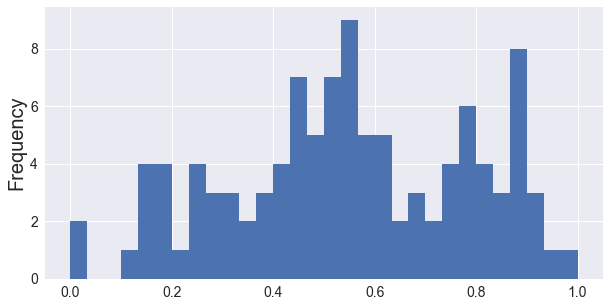

In [54]:
df_week.nCnt.plot(kind = "hist", bins = 30);

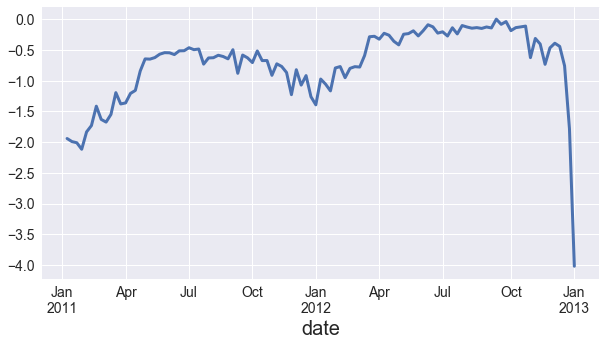

In [55]:
# get log of the power
df_week['log_power'] = df_week.nCnt.apply(lambda x: np.log(x))
df_week.log_power.plot()

The log transformation doesnt help the plot to become flatter so, it's not a useful thing to do. 

In [56]:
df_week.drop('log_power', axis=1, inplace=True)

Let's divide the dataset and test the model against the last 5 months

In [57]:
week_train = df_week.iloc[:-23].copy()
week_test = df_week.iloc[-23:].copy()

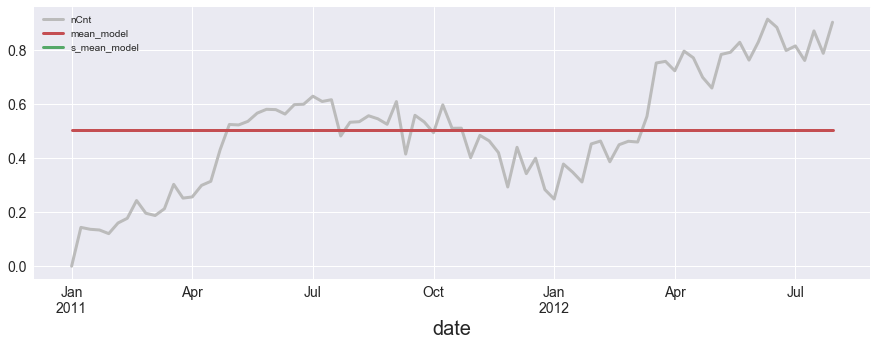

In [58]:
# Mean 
week_mean = week_train.nCnt.mean()
week_train['mean_model'] = week_mean
week_train.loc[:, ['nCnt','mean_model','s_mean_model']].plot(color=['#bbbbbb','r','g'], figsize=(15,5));

In [62]:
model_mean_RMSE = RMSE(week_train.mean_model, week_train.nCnt)
model_mean_RMSE

0.21454293332996938

In [63]:
# Save this in a dataframe
results_week = pd.DataFrame(columns=["Model", "RMSE"])
results_week.loc[0,"Model"] = "Mean"
results_week.loc[0,"RMSE"] = model_mean_RMSE
results_week

Model  RMSE
0  Mean  0.21

In [64]:
# Convert date in datetimedelta figure starting from zero
week_train["time_index"] = np.arange(1,len(week_train)+1)
week_train.tail()

atemp  nCnt  smoothed  season_1  season_2  season_3  season_4  \
date                                                                        
2012-07-01   0.67  0.81      0.81         0         0         1         0   
2012-07-08   0.74  0.76      0.79         0         0         1         0   
2012-07-15   0.67  0.87      0.81         0         0         1         0   
2012-07-22   0.68  0.79      0.83         0         0         1         0   
2012-07-29   0.68  0.90      0.84         0         0         1         0   

            mean_model  time_index  
date                                
2012-07-01         0.5          79  
2012-07-08         0.5          80  
2012-07-15         0.5          81  
2012-07-22         0.5          82  
2012-07-29         0.5          83

### Linear Regression

In [65]:
## Now plot linear regression between demand and time_index
model_linear = smf.ols('nCnt ~ time_index', data = week_train).fit()
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nCnt   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     106.1
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           2.21e-16
Time:                        16:42:54   Log-Likelihood:                 44.718
No. Observations:                  83   AIC:                            -85.44
Df Residuals:                      81   BIC:                            -80.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2201      0.032      6.951      0.000       0.157       0.283
time_index     0.0067      0.001     10.298      0.000       0.005       0.008
==============================================================================
Omnibus:                        6.882   Durbin-Watson:                   0.266
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                3.793
Skew:                          -0.316   Prob(JB):                        0.150
Kurtosis:                       2.164   Cond. No.                         97.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The slope is nearly zero, but surprisingly the p-value is effectively zero, which indicates the slope should be considered non-zero. So that slight slope is legitimate, but it will give us only a tiny improvement over the mean value.

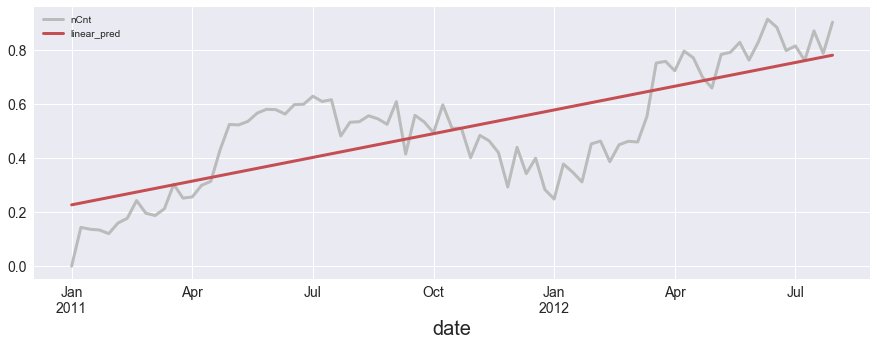

In [66]:
model_linear_pred = model_linear.predict()
week_train['linear_pred'] = model_linear_pred
# Plot the prediction line
week_train.loc[:, ['nCnt','linear_pred']].plot(figsize=(15,5), color=['#bbbbbb','r']);

In [67]:
# Root Mean Squared Error (RMSE) for linear
model_linear_RMSE = RMSE(week_train.linear_pred, week_train.nCnt)

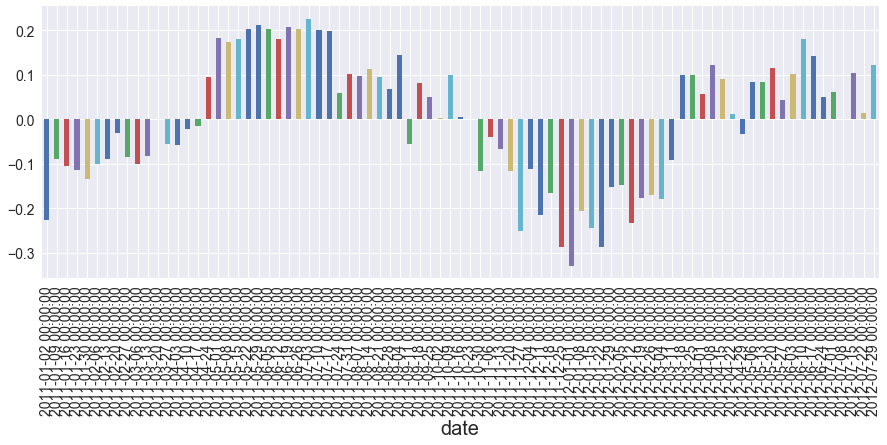

In [68]:
# Plot the residual
plt.figure(figsize=(15,5))
model_linear.resid.plot(kind='bar');

The time pattern is evident in the residual plot. A sinusoidal signal with a period at about 11 months. 

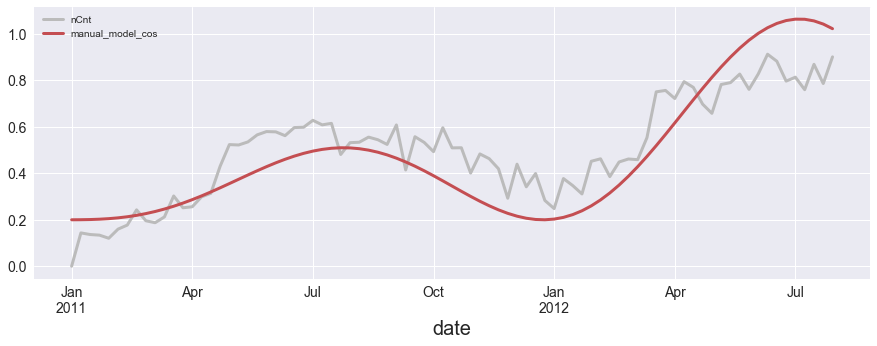

In [69]:
def manual_model(time_indices):
    resolution = 0.5
    period = 10.5/2*np.pi   #10.5 months fits best
    amplitud = 0.25
    amp_adj = 0.044         # precision Adjusted amplitude retrieved by trial and error
    return amplitud*amp_adj*time_indices * np.sin(1/period*time_indices)**2 +0.2

manual_model_preds = manual_model(week_train.time_index.values)
week_train['manual_model_cos'] = manual_model_preds

# Plot the prediction line
week_train.loc[:, ['nCnt','manual_model_cos']].plot(figsize=(15,5), color=['#bbbbbb','r']);

Of course this method also misses all of the week-to-week fluctuations.

In [70]:
# Root Mean Squared Error (RMSE) for manual
model_manual_RMSE = RMSE(week_train.manual_model_cos, week_train.nCnt)

#### RMSE

In [71]:
results_week.loc[1,"Model"] = "Linear"
results_week.loc[1,"RMSE"] = model_linear_RMSE

results_week.loc[2,"Model"] = "Manual"
results_week.loc[2,"RMSE"] = model_manual_RMSE
results_week.head()

Model  RMSE
0    Mean  0.21
1  Linear  0.14
2  Manual  0.13

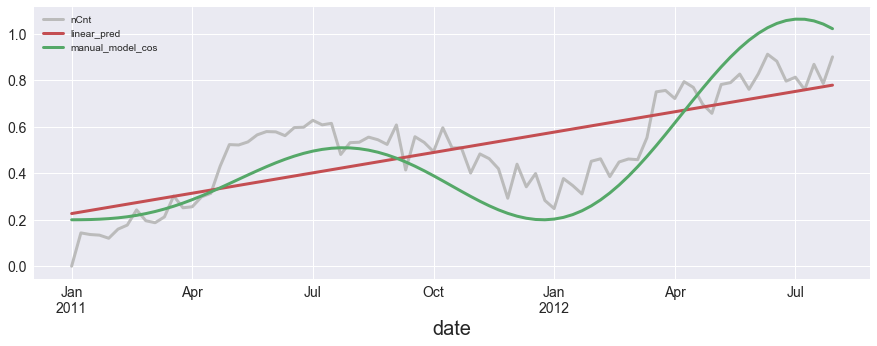

In [72]:
# Plot the prediction lines
week_train.loc[:, ['nCnt','linear_pred','manual_model_cos']]\
    .plot(figsize=(15,5), color=['#bbbbbb', 'r','g','b']);

## Linear Model with Regressor

In [73]:
model_linear_quantity = smf.ols('nCnt ~ atemp', data=week_train).fit()
week_train["linear_regression"] = model_linear_quantity.predict()

In [75]:
# Root Mean Squared Error (RMSE) for linear_quant
model_linQ_RMSE = RMSE(week_train.linear_regression, week_train.nCnt)

results_week.loc[3,"Model"] = "linear_regression"
results_week.loc[3,"RMSE"] = model_linQ_RMSE
results_week

Model  RMSE
0               Mean  0.21
1             Linear  0.14
2             Manual  0.13
3  linear_regression  0.15

## Random Walk Model

In [76]:
week_train["shift_1_pred"] = week_train.nCnt.shift()
week_train.loc[:,['nCnt','shift_1_pred']].head(5)

nCnt  shift_1_pred
date                          
2011-01-02  0.00           NaN
2011-01-09  0.14          0.00
2011-01-16  0.14          0.14
2011-01-23  0.13          0.14
2011-01-30  0.12          0.13

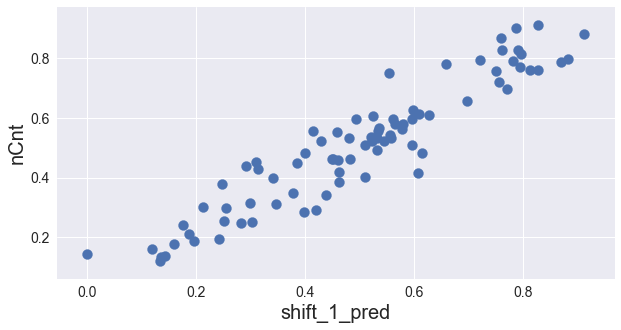

In [77]:
week_train.plot(kind="scatter", y="nCnt", x = "shift_1_pred", s=100);

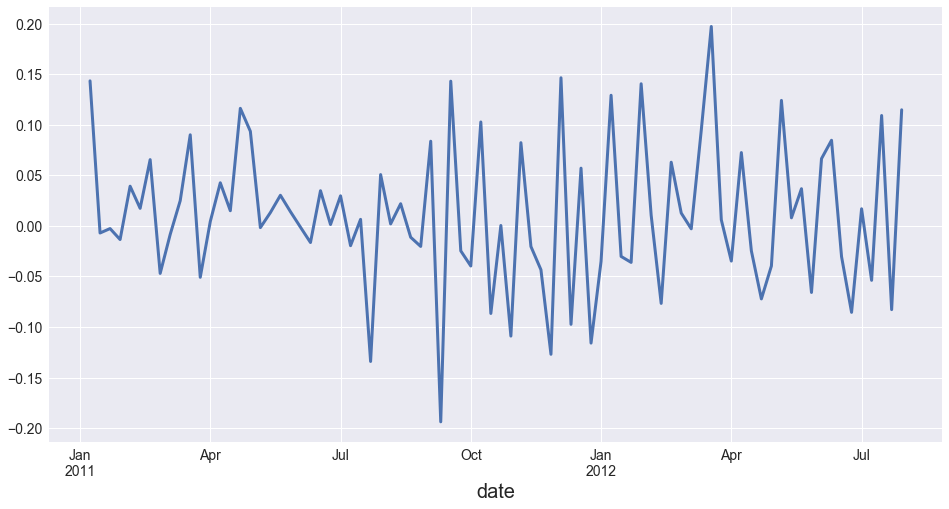

In [78]:
# Lets plot the one-day difference curve
(week_train.nCnt - week_train.shift_1_pred).plot(figsize=(16,8));

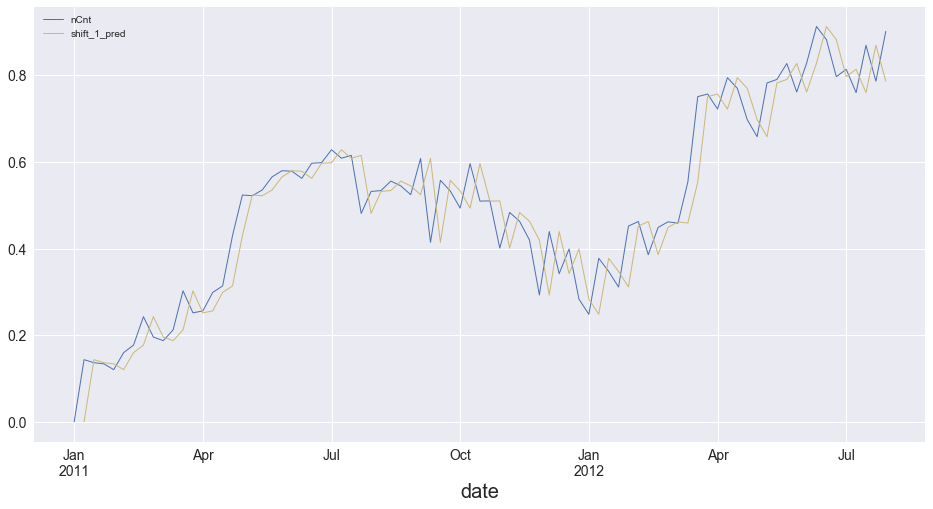

In [79]:
week_train["shift_1_pred"] = week_train.shift_1_pred
week_train.loc[:, ['nCnt', 'shift_1_pred']].plot(color=['b', 'y'], figsize=(16,8), linewidth=1);

In [80]:
# Root Mean Squared Error (RMSE)
model_random_RMSE = RMSE(week_train.shift_1_pred, week_train.nCnt)

results_week.loc[4,"Model"] = "shift_1_pred"
results_week.loc[4,"RMSE"] = model_random_RMSE
results_week

Model   RMSE
0               Mean   0.21
1             Linear   0.14
2             Manual   0.13
3  linear_regression   0.15
4       shift_1_pred  0.074

#### Simple Moving Average

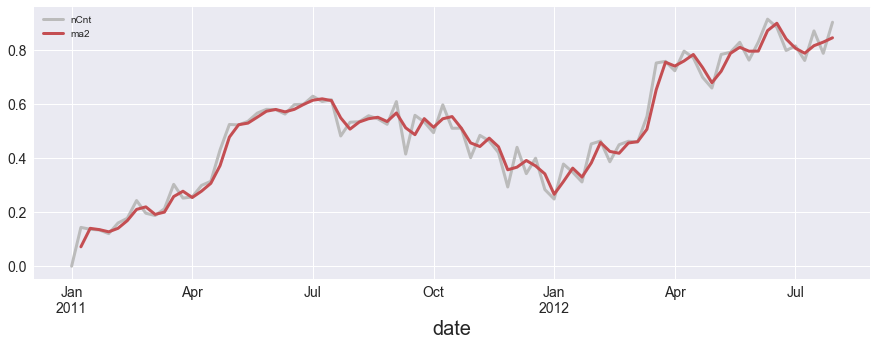

In [81]:
# For smoothing the values we can use 2 week Moving Averages 
week_train['ma2'] = week_train.nCnt.rolling(window=2).mean()
week_train.loc[:, ['nCnt', 'ma2']].plot(color=['#bbbbbb', 'r'], figsize=(15,5));

The long-term forecasts from the SMA model are a horizontal straight line, just as in the random walk model. Thus, the SMA model assumes that there is no trend in the data. However, whereas the forecasts from the random walk model are simply equal to the last observed value, the forecasts from the SMA model are equal to a weighted average of recent values.

    

In [82]:
model_MA2_forecast = week_train.nCnt.tail(14).mean()

In [83]:
# Root Mean Squared Error (RMSE)
model_MA2_RMSE = RMSE(week_train.ma2, week_train.nCnt)

results_week.loc[5,"Model"] = "Moving Average 2"
results_week.loc[5,"RMSE"] = model_MA2_RMSE
results_week

Model   RMSE
0               Mean   0.21
1             Linear   0.14
2             Manual   0.13
3  linear_regression   0.15
4       shift_1_pred  0.074
5   Moving Average 2  0.037

In [84]:
# AUGMENTED DICKEY FULLER TEST FOR STATIONARITY
def adf(ts):
    
    # Determing rolling statistics
    rolmean = ts.rolling(window=2).mean()
    rolstd = ts.rolling(window=2).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original', Linewidth=4, alpha=0.5)
    mean = plt.plot(rolmean, color='black', label='Rolling Mean', linestyle='--')
    std = plt.plot(rolstd, color='orange', label = 'Rolling Std', linestyle='--')
    plt.legend(loc='best')
    plt.grid('on')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Calculate ADF factors
    adftest = adfuller(ts, autolag='AIC')
    adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','# of Lags Used',
                                              'Number of Observations Used'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    return adfoutput

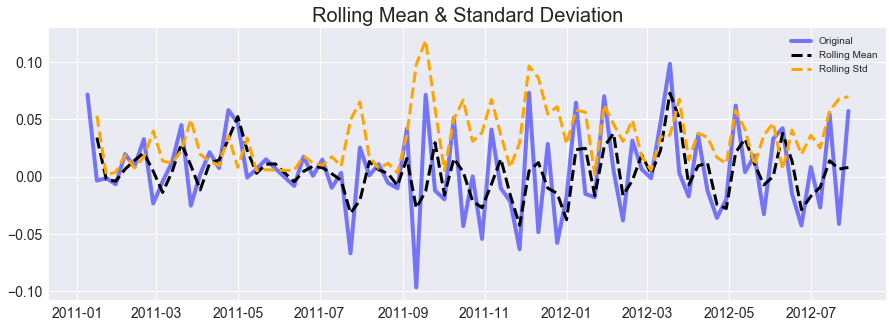

In [89]:
# Test remaining part for Stationary
ts = week_train.nCnt - week_train.ma2
ts.dropna(inplace=True)
fig = plt.figure(figsize=(15,5))
adf(ts)
fig.savefig('../reports/img/Q5ADFTest.png', bbox_inches='tight')

The Test Statistic is lower than all critical values, so we reject the null hypothesis of non-stationarity and say that the series **is stationary**. Even though the variance is not constant, the changes are minimal. 


## Simple Exponential Smoothing Model (SES)

Instead of equally weighting each of the observation, in the SES model we give more weightage to the recent observations and less to the older ones. This is done by the using a smoothing variable like alpha

$$ \hat{y_t} = \alpha y_{t-1} + (1-\alpha)\hat{y_{t-1}} $$

In [93]:
week_train['exp2'] = week_train.nCnt.ewm(halflife=1).mean()

In [94]:
halflife = 1
alpha = 1 - np.exp(np.log(0.5)/halflife)    # Smoothing constant
alpha

0.5

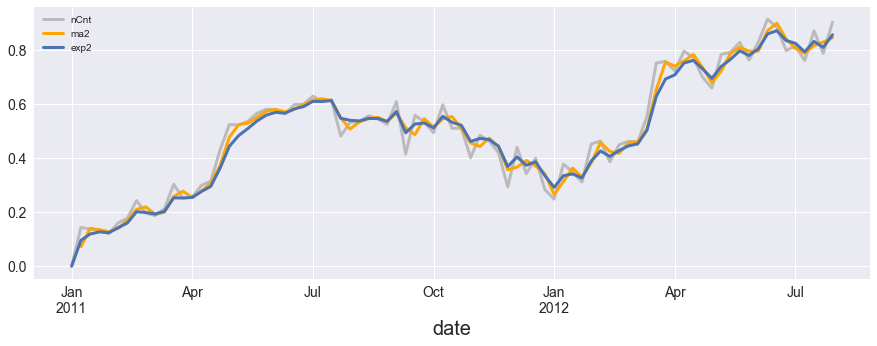

In [95]:
week_train.loc[:, ["nCnt", "ma2", "exp2"]].plot(color=['#bbbbbb','orange','b'], figsize=(15, 5));

In [96]:
# Root Mean Squared Error (RMSE)
model_Exp2_RMSE = RMSE(week_train.exp2, week_train.nCnt)

results_week.loc[6,"Model"] = "SES"
results_week.loc[6,"RMSE"] = model_Exp2_RMSE
results_week

Model   RMSE
0               Mean   0.21
1             Linear   0.14
2             Manual   0.13
3  linear_regression   0.15
4       shift_1_pred  0.074
5   Moving Average 2  0.037
6                SES  0.036

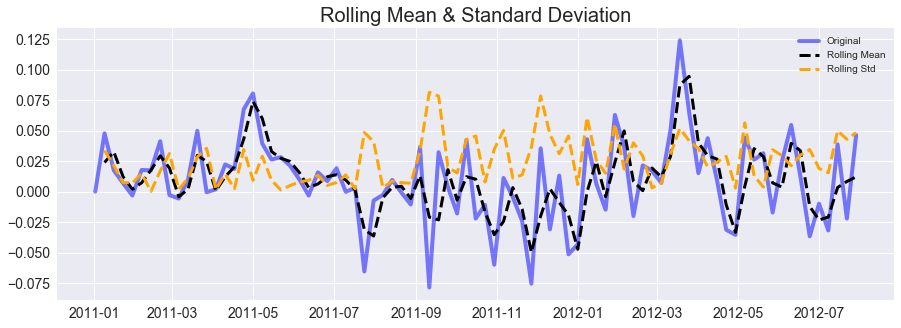

Test Statistic                -7.56e+00
p-value                        3.03e-11
# of Lags Used                 0.00e+00
Number of Observations Used    8.20e+01
Critical Value (1%)           -3.51e+00
Critical Value (5%)           -2.90e+00
Critical Value (10%)          -2.59e+00
dtype: float64

In [97]:
# Test remaining part for Stationary
ts = week_train.nCnt - week_train.exp2
ts.dropna(inplace = True)
plt.figure(figsize=(15,5))
adf(ts)

The ADF test indicates that the series is stationary

## Differencing

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. We have already done first order difference earlier

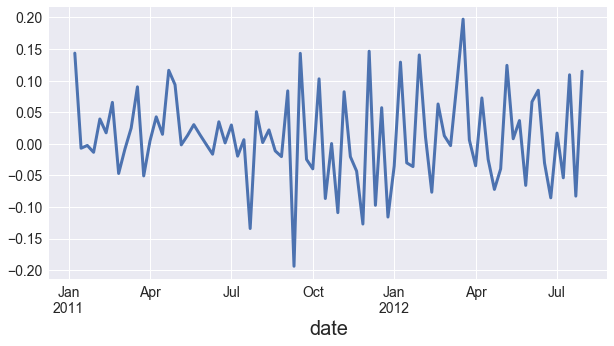

In [98]:
# the first order difference
diff = (week_train.nCnt - week_train.shift_1_pred)
diff.plot();

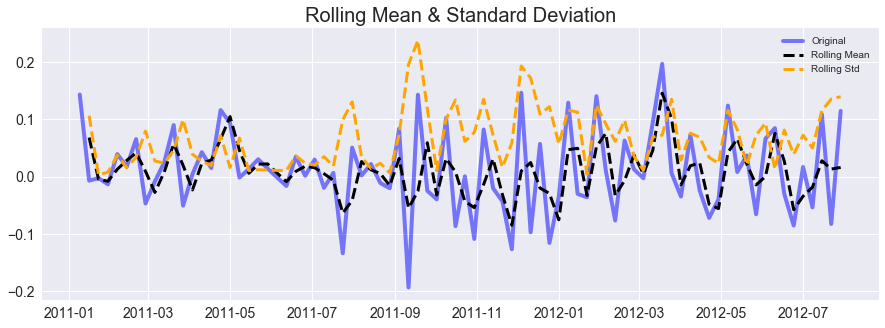

Test Statistic                -1.26e+01
p-value                        1.44e-23
# of Lags Used                 0.00e+00
Number of Observations Used    8.10e+01
Critical Value (1%)           -3.51e+00
Critical Value (5%)           -2.90e+00
Critical Value (10%)          -2.59e+00
dtype: float64

In [99]:
# Test remaining part for Stationary
ts = diff
ts.dropna(inplace=True)
plt.figure(figsize=(15,5))
adf(ts)

Stationary series!

## Time Series Decomposition

We can also decompose the time series into trend and seasonality

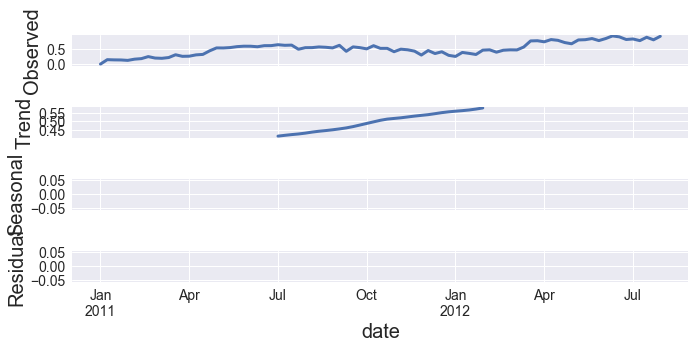

In [100]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(week_train.nCnt, model="additive")
decomposition.plot();

In [101]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
week_train['power_decomp'] = trend

In [102]:
# Root Mean Squared Error (RMSE)
model_Decomp_RMSE = RMSE(week_train.power_decomp, week_train.nCnt)

results_week.loc[7,"Model"] = "Decomp"
results_week.loc[7,"RMSE"] = model_Decomp_RMSE
results_week

Model   RMSE
0               Mean   0.21
1             Linear   0.14
2             Manual   0.13
3  linear_regression   0.15
4       shift_1_pred  0.074
5   Moving Average 2  0.037
6                SES  0.036
7             Decomp   0.15

In [ ]:
# Test remaining part for Stationary
ts = decomposition.resid
ts.dropna(inplace = True)
adf(ts)

## Auto Regressive Models

In [105]:
# Exp2 is so far the best model so we'll use the difference to use the ARIMA model: 
diff = (week_train.nCnt - week_train.exp2)
ts_diff = diff.copy()          ## diff = (week_train.nCnt - week_train.shift_1_pred)
ts_diff.dropna(inplace=True)

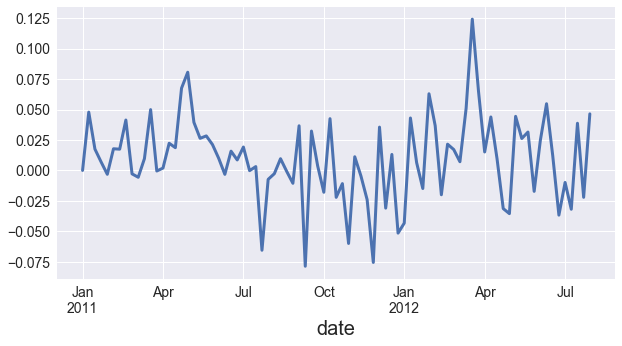

In [106]:
ts_diff.plot()

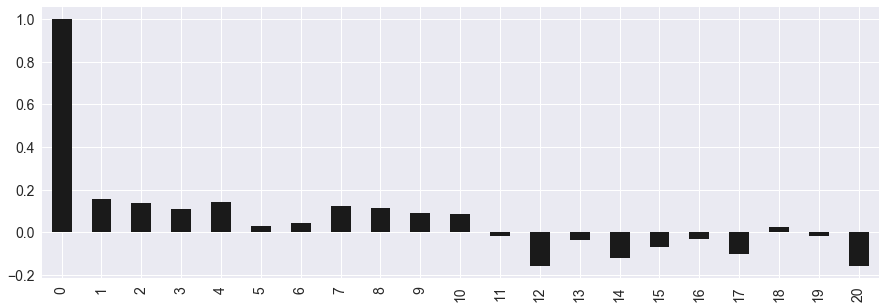

In [107]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_diff, nlags=20)
ACF = pd.Series(lag_acf)
ACF.plot(kind="bar", color='k', figsize = (15,5));

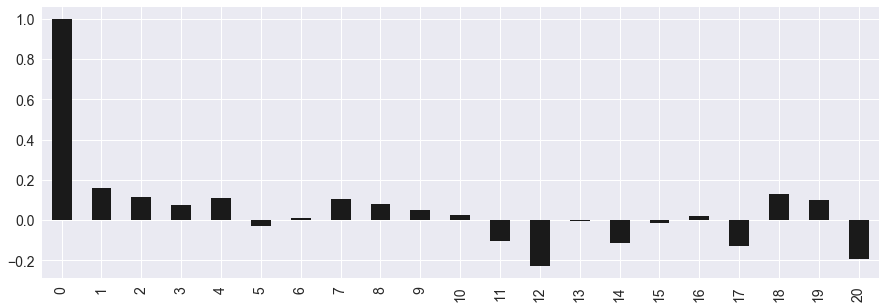

In [108]:
lag_pacf = pacf(ts_diff, nlags=20, method='ols')
PACF = pd.Series(lag_pacf)
PACF.plot(kind="bar", color='k', figsize = (15,5));

### Selecting p and q for the ARIMA model

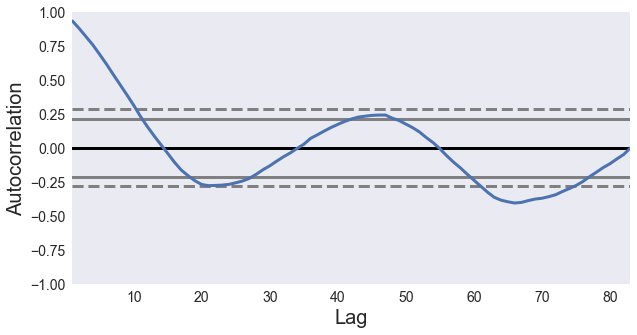

In [109]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(week_train.exp2)
plt.show()

p<10

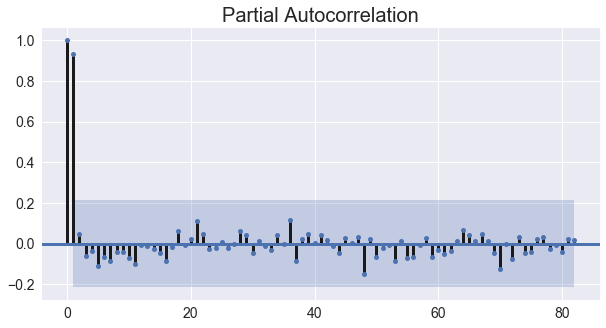

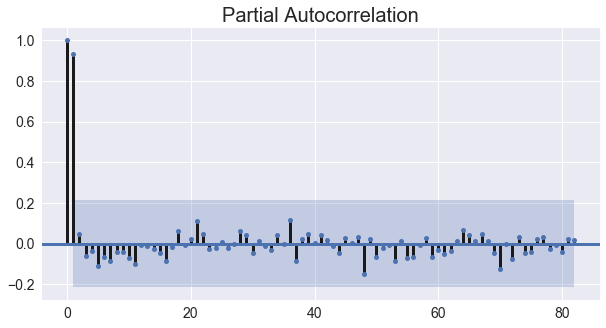

In [111]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(week_train.exp2)

q=2

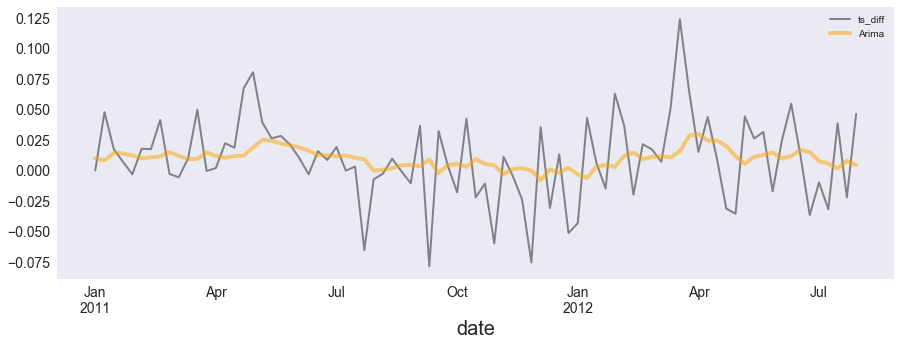

In [112]:
from statsmodels.tsa.arima_model import ARIMA
# Running the ARIMA Model(2,0,2)
model_AR1MA = ARIMA(ts_diff, order=(1,0,1))
results_ARIMA = model_AR1MA.fit(disp=-1)

# Plot results:
fig = plt.figure(figsize=(15,5))
ts_diff.plot(color='k', linewidth=2, label='ts_diff', alpha=0.5);
results_ARIMA.fittedvalues.plot(color='orange', label='Arima', linewidth=4, alpha=0.5);
plt.legend()
plt.grid()
plt.show()

In [113]:
RMSE(results_ARIMA.fittedvalues, ts_diff)

0.033557704259414012

In [118]:
# Get the predictions of the differenciation: 
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
# Undo 1 degree differenciation: 
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# Add the first record that thanks to differenciation, got removed. 
predictions_ARIMA = pd.Series(week_train.nCnt.iloc[0], index=week_train.nCnt.index) # SERIES with 0 as values
# either add or sub, depending on the series switch if it comes out upside down
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum, fill_value=0)
# Add to Dataframe
week_train['ARIMA'] = predictions_ARIMA

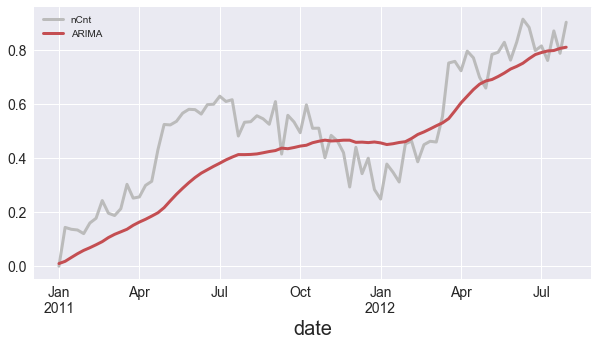

In [119]:
week_train.loc[:, ['nCnt', 'ARIMA']].plot(color=['#bbbbbb','r']);

ARIMA isn't always easy to fine-tune, but it seems to capture the trend well enough and the cycle but not that well enough. 

In [120]:
# Root Mean Squared Error (RMSE)
model_ARIMA_RMSE = RMSE(week_train.ARIMA, week_train.nCnt)

results_week.loc[8,"Model"] = "ARIMA"
results_week.loc[8,"RMSE"] = model_ARIMA_RMSE
results_week

Model   RMSE
0               Mean   0.21
1             Linear   0.14
2             Manual   0.13
3  linear_regression   0.15
4       shift_1_pred  0.074
5   Moving Average 2  0.037
6                SES  0.036
7             Decomp   0.15
8              ARIMA   0.14

In [122]:
results_week.iloc[[1,2,3,8]]

Model  RMSE
1             Linear  0.14
2             Manual  0.13
3  linear_regression  0.15
8              ARIMA  0.14

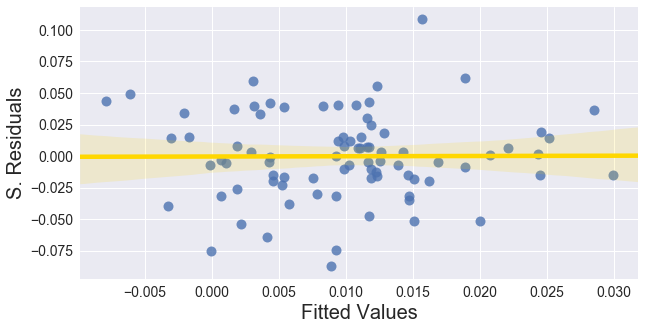

In [123]:
fitted_values = pd.Series(results_ARIMA.fittedvalues, name="Fitted Values")
residuals = pd.Series(results_ARIMA.resid, name="S. Residuals")
#s_residuals = pd.Series(mlr_all_var.resid_pearson, name="S. Residuals Normalized")
fig=plt.figure()
sns.regplot(fitted_values, residuals,  fit_reg=True, line_kws = {"color":"gold"})
plt.show()

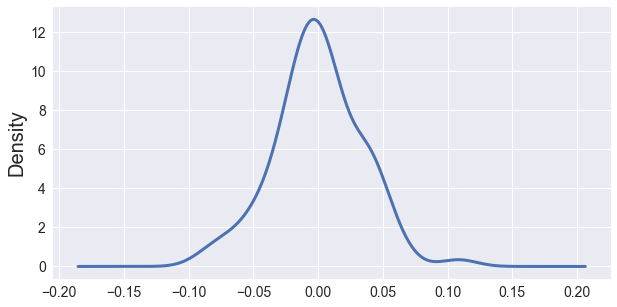

In [124]:
results_ARIMA.resid.plot(kind='kde')

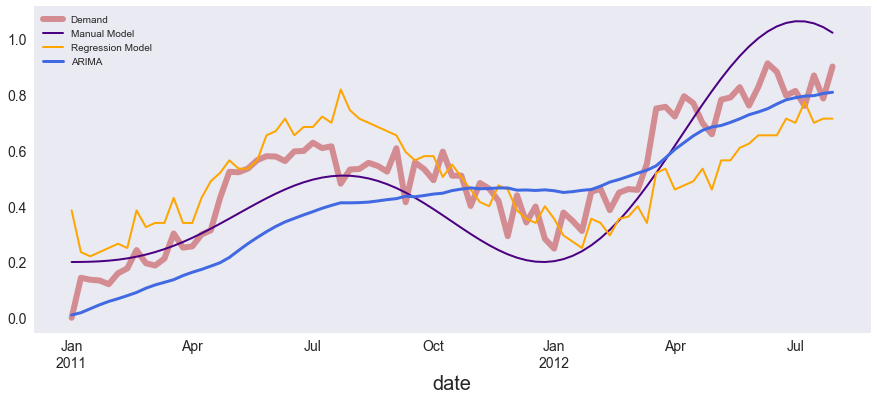

In [125]:
# Plot all good models
fig = plt.figure(figsize=(15,6))
week_train.loc[:, 'nCnt'].plot(color='r', linewidth = 6, label='Demand', alpha=0.6);
week_train.loc[:, 'manual_model_cos'].plot(color='indigo', linewidth = 2, label='Manual Model');
week_train.loc[:, 'linear_regression'].plot(color='orange', linewidth = 2, label='Regression Model');
#week_train.loc[:,'shift_1_pred'].plot(color='green', linewidth = 2, label='Shift 1');
#week_train.loc[:,'ma2'].plot(color='royalblue', linewidth = 3, label='Moving Average');
#week_train.loc[:,'exp2'].plot(color='orange', linewidth = 3, label='Exp Average');
week_train.loc[:,'ARIMA'].plot(color='royalblue', linewidth = 3, label='ARIMA');
plt.grid()
plt.legend()
plt.show()
fig.savefig('../reports/img/Q5AllPredictions.png', bbox_inches='tight')

### Forecast the 14 days in the test set

We will use the 3 best models to predict the demand. 

In [126]:
# create indices for test data
week_test['time_index'] = range(week_train.time_index[-1]+1, week_train.time_index[-1]+24)
week_test['exp2'] = week_test.nCnt.ewm(halflife=1).mean()

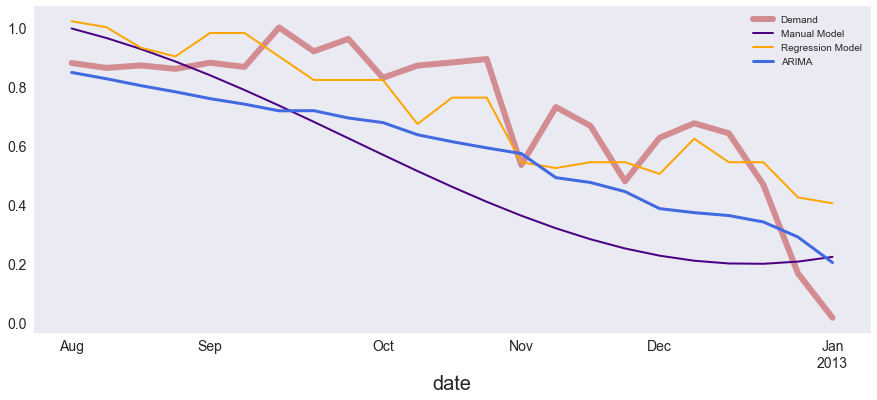

In [127]:
# create indices for test data
week_test['time_index'] = range(week_train.time_index[-1]+1, week_train.time_index[-1]+24)

# Forecast using manual model
model_manual_forecast = manual_model(week_test.time_index.values)
week_test['manual_model_sin_forecast'] = model_manual_forecast

# Forecast using Regression model 
model_regression_forecast = smf.ols('nCnt ~ atemp', data=week_test).fit()
week_test["linear_regression"] = model_regression_forecast.predict()

# Forecast using the ARIMA model 
model_AR1MA_forecast = ARIMA(week_test.nCnt-week_test.exp2, order=(1,0,1))
results_ARIMA_f = model_AR1MA_forecast.fit(disp=-1)
#Undifferenciate
predictions_ARIMA_diff_f = pd.Series(results_ARIMA_f.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum_f = predictions_ARIMA_diff_f.cumsum()
predictions_ARIMA_f = pd.Series(week_test.nCnt.iloc[0], index=week_test.nCnt.index) # SERIES with 0 as values
# either add or sub, depending on the series switch if it comes out upside down
predictions_ARIMA_f = predictions_ARIMA_f.add(predictions_ARIMA_diff_cumsum_f, fill_value=0)
# Add to Dataframe
week_test['ARIMA'] = predictions_ARIMA_f

# Plot the prediction line
fig = plt.figure(figsize=(15,6))
week_test.loc[:, 'nCnt'].plot(color='r', linewidth = 6, label='Demand', alpha=0.6);
week_test.loc[:, 'manual_model_sin_forecast'].plot(color='indigo', linewidth = 2, label='Manual Model');
week_test.loc[:, 'linear_regression'].plot(color='orange', linewidth = 2, label='Regression Model');
week_test.loc[:,'ARIMA'].plot(color='royalblue', linewidth = 3, label='ARIMA');
plt.legend()
plt.grid()
plt.show()
fig.savefig('../reports/img/Q5Test.png', bbox_inches='tight')

In [129]:
final_prediction = pd.DataFrame(columns=['model','RMSE'])

final_prediction.loc[0,'model'] = 'Manual'
final_prediction.loc[0,'RMSE'] = RMSE(week_test.manual_model_sin_forecast, week_test.nCnt)
final_prediction.loc[1,'model'] = 'Linear Regression'
final_prediction.loc[1,'RMSE'] = RMSE(week_test.linear_regression, week_test.nCnt)
final_prediction.loc[2,'model'] = 'Arima'
final_prediction.loc[2,'RMSE'] = RMSE(week_test.ARIMA, week_test.nCnt)

final_prediction

model  RMSE
0             Manual  0.29
1  Linear Regression  0.15
2              Arima  0.19